In [28]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
from hyperopt import hp
from hyperopt.pyll import scope
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, matthews_corrcoef, make_scorer, confusion_matrix, precision_score, recall_score, f1_score
from matplotlib.legend_handler import HandlerLine2D
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.pipeline import make_pipeline, Pipeline
from time import time
from tqdm import tqdm
from sklearn.ensemble import BaggingClassifier
import os, pickle

In [202]:
# Read data
%pwd
train = pd.read_csv("./train.csv", low_memory=False, header=0)
train['sic'].value_counts()

7372.0    1064
3674.0     914
1311.0     890
7370.0     805
2834.0     760
          ... 
6510.0       1
7819.0       1
900.0        1
3231.0       1
6726.0       1
Name: sic, Length: 403, dtype: int64

# Q1 Apply Altman’s Z-score with a cut-off value at 2.675 for classification.

In [203]:
test = pd.read_csv("./test.csv", low_memory=False, header=0)


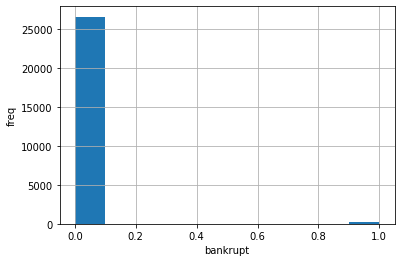

In [204]:
plt.figure()
train['bankrupt'].hist()
plt.xlabel('bankrupt')
plt.ylabel('freq')
plt.show()

In [205]:
train['Z']=1.2*train['Altman_X1']+1.4*train['Altman_X2']+3.3*train['Altman_X3']+0.6*train['Altman_X4']+1*train['Altman_X5']

train['predicted_bankrupt']=0
for i in range(len(train['Z'])):
    if train['Z'][i]>=2.675:
        train['predicted_bankrupt'][i]=0
    else:
        train['predicted_bankrupt'][i]=1
        

C:\Users\Xingy\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Xingy\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


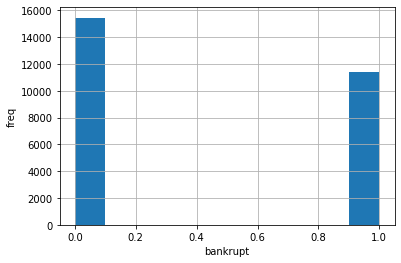

In [206]:
plt.figure()
train['predicted_bankrupt'].hist()
plt.xlabel('bankrupt')
plt.ylabel('freq')
plt.show()

In [207]:
# Import libraries
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [208]:


# Create confusion matrix of validation data
cm = confusion_matrix(train['bankrupt'],train['predicted_bankrupt'])
TN, FP, FN, TP = cm.ravel()
print("Confusion Matrix: \n", cm)
print("True negative: %s, False positive: %s, False negative: %s, True positive: %s" %(TN, FP, FN, TP))

# Performance of decision tree model on validation data
print("Accuracy: ", accuracy_score(train['bankrupt'],train['predicted_bankrupt']))
print("Recall: ", recall_score(train['bankrupt'],train['predicted_bankrupt']))
print("Precision: ", precision_score(train['bankrupt'],train['predicted_bankrupt']))
from sklearn.metrics import matthews_corrcoef
print("MCC: ", matthews_corrcoef(train['bankrupt'],train['predicted_bankrupt']))
print("F1: ", f1_score(train['bankrupt'],train['predicted_bankrupt']))

Confusion Matrix: 
 [[15433 11205]
 [   17   164]]
True negative: 15433, False positive: 11205, False negative: 17, True positive: 164
Accuracy:  0.5815653081770387
Recall:  0.9060773480662984
Precision:  0.01442519130970182
MCC:  0.08042631779601146
F1:  0.028398268398268398


In [254]:
# Read data
%pwd
train2=pd.read_csv("./train.csv", low_memory=False, header=0)




# Q2 Compare prediction models built using Logistic regression, CART decision tree, and XGBoost (with XGBoost random_state=1). 

In [248]:
x_var=['Altman_X1','Altman_X2','Altman_X3','Altman_X4','Altman_X5']
y_var='bankrupt'

In [260]:
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

In [213]:
#Q2 XGBOOST
from copy import deepcopy
train = deepcopy(train2)
np.random.seed(1)
auc_scores = []
all_y_preds = []
all_y_proba = []
all_y_true = []
##a=[]

kf = StratifiedKFold(n_splits=5, random_state=1234, shuffle=False)
kf.get_n_splits(train[x_var], train[y_var])

for train_index, test_index in kf.split(train[x_var], train[y_var]):
    curr_train, curr_test = train.iloc[train_index], train.iloc[test_index]
    X_train = curr_train[x_var]
    y_train = curr_train[y_var]
    
    X_test = curr_test[x_var]
    y_test = curr_test[y_var]
    
    XG = XGBClassifier(random_state =1)
    XG.fit(X_train, y_train)
    y_preds = XG.predict(X_test)
    
    y_proba = XG.predict_proba(X_test)
   
    ##a.append(roc_auc_score(y_test.values, y_proba[:, 1]))
    
    all_y_preds.extend(y_preds)
    all_y_proba.extend(y_proba[:, 1])
    all_y_true.extend(y_test)

    

    
print("accuracy:", accuracy_score(all_y_true, all_y_preds))
print("auc: ",roc_auc_score(all_y_true,all_y_proba))
print("precision:", precision_score(all_y_true, all_y_preds))
print("recall:", recall_score(all_y_true, all_y_preds))
print("MCC:", matthews_corrcoef(all_y_true, all_y_preds))
print("F1:", f1_score(all_y_true, all_y_preds))

confusion_matrix(all_y_true, all_y_preds)
   

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


accuracy: 0.9925053133972184
auc:  0.890745638578046
precision: 0.2222222222222222
recall: 0.04419889502762431
MCC: 0.09648671909706168
F1: 0.07373271889400922


array([[26610,    28],
       [  173,     8]], dtype=int64)

In [257]:
#Q2 Logistic regression
from copy import deepcopy
train = deepcopy(train2)

auc_scores = []
all_y_preds = []
all_y_proba = []
all_y_true = []

kf = StratifiedKFold(n_splits=5, random_state=1, shuffle=False)
kf.get_n_splits(train[x_var], train[y_var])

for train_index, test_index in kf.split(train[x_var], train[y_var]):
    curr_train, curr_test = train.iloc[train_index], train.iloc[test_index]
    X_train = curr_train[x_var]
    y_train = curr_train[y_var]
    
    X_test = curr_test[x_var]
    y_test = curr_test[y_var]
    
    model = LogisticRegression(random_state=1)
    model.fit(X_train, y_train)
    y_preds = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    all_y_preds.extend(y_preds)
    all_y_proba.extend(y_proba[:, 1])
    all_y_true.extend(y_test)

    

    
print("accuracy:", accuracy_score(all_y_true, all_y_preds))
print("auc: ",roc_auc_score(all_y_true,all_y_proba))
print("precision:", precision_score(all_y_true, all_y_preds))
print("recall:", recall_score(all_y_true, all_y_preds))
print("MCC:", matthews_corrcoef(all_y_true, all_y_preds))
print("F1:", f1_score(all_y_true, all_y_preds))

confusion_matrix(all_y_true, all_y_preds)

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


accuracy: 0.9932510533576941
auc:  0.9136051227445194
precision: 0.5
recall: 0.04419889502762431
MCC: 0.14719355521340557
F1: 0.08121827411167512


array([[26630,     8],
       [  173,     8]], dtype=int64)

In [39]:
#Q3 CART
from copy import deepcopy
train = deepcopy(train2)

auc_scores = []
all_y_preds = []
all_y_proba = []
all_y_true = []

kf = StratifiedKFold(n_splits=5, random_state=1, shuffle=False)
kf.get_n_splits(train[x_var], train[y_var])

for train_index, test_index in kf.split(train[x_var], train[y_var]):
    curr_train, curr_test = train.iloc[train_index], train.iloc[test_index]
    X_train = curr_train[x_var]
    y_train = curr_train[y_var]
    
    X_test = curr_test[x_var]
    y_test = curr_test[y_var]
    
    tree = DecisionTreeClassifier(random_state=1)

                                
    tree.fit(X_train, y_train)
    y_preds = tree.predict(X_test)
    y_proba = tree.predict_proba(X_test)
    all_y_preds.extend(y_preds)
    all_y_proba.extend(y_proba[:, 1])
    all_y_true.extend(y_test)

    

    
print("accuracy:", accuracy_score(all_y_true, all_y_preds))

print("precision:", precision_score(all_y_true, all_y_preds))
print("recall:", recall_score(all_y_true, all_y_preds))
print("MCC:", matthews_corrcoef(all_y_true, all_y_preds))
print("F1:", f1_score(all_y_true, all_y_preds))

confusion_matrix(all_y_true, all_y_preds)

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


accuracy: 0.987807151646221
precision: 0.11170212765957446
recall: 0.11602209944751381
MCC: 0.10770435865839989
F1: 0.1138211382113821


array([[26471,   167],
       [  160,    21]], dtype=int64)

# Q3 Experiment with 3 class imbalance tachniques for Decision Tree Claasifier

In [250]:
from collections import Counter
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN

In [255]:
#cart decision tree
#1)SMOTE for oversampling to target a 1:2 minority: majority ratio by setting sampling_strategy = 0.5 

from copy import deepcopy
train = deepcopy(train2)

auc_scores = []
all_y_preds = []
all_y_proba = []
all_y_true = []

kf = StratifiedKFold(n_splits=5, random_state=1, shuffle=False)
kf.get_n_splits(train[x_var], train[y_var])

for train_index, test_index in kf.split(train[x_var], train[y_var]):
    curr_train, curr_test = train.iloc[train_index], train.iloc[test_index]
    X_train = curr_train[x_var]
    y_train = curr_train[y_var]
    #print(f'Original dataset shape {Counter(y_train)}')
    smote_only = SMOTE(random_state=1234, sampling_strategy=0.5)
    X_res_smote, y_res_smote = smote_only.fit_resample(X_train, y_train)
    X_test = curr_test[x_var]
    y_test = curr_test[y_var]
    
    tree1=DecisionTreeClassifier(random_state=1)
    tree1.fit(X_res_smote, y_res_smote)
    y_preds = tree1.predict(X_test)
    y_proba = tree1.predict_proba(X_test)
    all_y_preds.extend(y_preds)
    all_y_proba.extend(y_proba[:, 1])
    all_y_true.extend(y_test)

    

    
print("accuracy:", accuracy_score(all_y_true, all_y_preds))

print("precision:", precision_score(all_y_true, all_y_preds))
print("recall:", recall_score(all_y_true, all_y_preds))
print("MCC:", matthews_corrcoef(all_y_true, all_y_preds))
print("F1:", f1_score(all_y_true, all_y_preds))

confusion_matrix(all_y_true, all_y_preds)



C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


accuracy: 0.9631231589544725
precision: 0.06465517241379311
recall: 0.3314917127071823
MCC: 0.13389899599691737
F1: 0.10820559062218216


array([[25770,   868],
       [  121,    60]], dtype=int64)

In [256]:
#SMOTE  (2) SMOTE (1:2 ratio) + Edited NN (5-NN method) 


from copy import deepcopy
train = deepcopy(train2)

auc_scores = []
all_y_preds = []
all_y_proba = []
all_y_true = []

kf = StratifiedKFold(n_splits=5, random_state=1, shuffle=False)
kf.get_n_splits(train[x_var], train[y_var])

for train_index, test_index in kf.split(train[x_var], train[y_var]):
    curr_train, curr_test = train.iloc[train_index], train.iloc[test_index]
    X_train = curr_train[x_var]
    y_train = curr_train[y_var]
    #print(f'Original dataset shape {Counter(y_train)}')
    smote_only = SMOTE(random_state=1234, sampling_strategy=0.5)

    ennObj = EditedNearestNeighbours(n_neighbors=5)
    smote_enn = SMOTEENN(smote=smote_only , enn= ennObj)
    X_res_smoteENN, y_res_smoteENN = smote_enn.fit_resample(X_train, y_train)
    X_test = curr_test[x_var]
    y_test = curr_test[y_var]
    
    tree2=DecisionTreeClassifier(random_state=1)
    tree2.fit(X_res_smoteENN, y_res_smoteENN)
    y_preds = tree2.predict(X_test)
    y_proba = tree2.predict_proba(X_test)
    all_y_preds.extend(y_preds)
    all_y_proba.extend(y_proba[:, 1])
    all_y_true.extend(y_test)

    

    
print("accuracy:", accuracy_score(all_y_true, all_y_preds))

print("precision:", precision_score(all_y_true, all_y_preds))
print("recall:", recall_score(all_y_true, all_y_preds))
print("MCC:", matthews_corrcoef(all_y_true, all_y_preds))
print("F1:", f1_score(all_y_true, all_y_preds))

confusion_matrix(all_y_true, all_y_preds)


C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


accuracy: 0.9461202878556247
precision: 0.062326869806094184
recall: 0.4972375690607735
MCC: 0.1619330033425991
F1: 0.11076923076923076


array([[25284,  1354],
       [   91,    90]], dtype=int64)

In [253]:
#(3) over-weighting rows with label=1 by 40 times 

from copy import deepcopy
train = deepcopy(train2)

auc_scores = []
all_y_preds = []
all_y_proba = []
all_y_true = []

kf = StratifiedKFold(n_splits=5, random_state=1, shuffle=False)
kf.get_n_splits(train[x_var], train[y_var])

for train_index, test_index in kf.split(train[x_var], train[y_var]):
    curr_train, curr_test = train.iloc[train_index], train.iloc[test_index]
    X_train = curr_train[x_var]
    y_train = curr_train[y_var]
    
    X_test = curr_test[x_var]
    y_test = curr_test[y_var]
    
    tree3 = DecisionTreeClassifier(class_weight={0: 1, 1: 40},random_state=1)

                                
    tree3.fit(X_train, y_train)
    y_preds = tree3.predict(X_test)
    y_proba = tree3.predict_proba(X_test)
    all_y_preds.extend(y_preds)
    all_y_proba.extend(y_proba[:, 1])
    all_y_true.extend(y_test)

    

    
print("accuracy:", accuracy_score(all_y_true, all_y_preds))

print("precision:", precision_score(all_y_true, all_y_preds))
print("recall:", recall_score(all_y_true, all_y_preds))
print("MCC:", matthews_corrcoef(all_y_true, all_y_preds))
print("F1:", f1_score(all_y_true, all_y_preds))

confusion_matrix(all_y_true, all_y_preds)

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


accuracy: 0.988142734628435
precision: 0.14871794871794872
recall: 0.16022099447513813
MCC: 0.14839752868376088
F1: 0.15425531914893617


array([[26472,   166],
       [  152,    29]], dtype=int64)

# Q4 Build final model using bayesian optimisation

In [45]:
#original dataset
train2

,gvkey,datadate,conm,at,cogs,csho,dvp,ebit,gp,ib,...,xido,xopr,mkvalt,sic,bankrupt,Altman_X1,Altman_X2,Altman_X3,Altman_X4,Altman_X5
0,1240,2002-01-31,ALBERTSON'S INC,15967.000,26094.000,407.000,0.0,1787.000,11837.000,501.000,...,0.000,35118.000,11701.2500,5411.0,0,0.064320,0.339074,0.111918,1.164072,2.375587
1,1655,2002-01-31,ANGELICA CORP,290.865,246.466,8.608,0.0,12.856,103.597,1.629,...,-24.338,326.107,101.5744,7200.0,0,0.161449,0.488845,0.044199,0.680060,1.203524
2,1864,2002-01-31,REX AMERICAN RESOURCES CORP,307.329,325.912,8.163,0.0,22.236,138.591,22.554,...,-0.245,438.069,240.4004,2860.0,0,0.300186,0.438319,0.072352,1.508575,1.511419
3,1878,2002-01-31,AUTODESK INC,902.444,124.903,55.644,0.0,131.804,822.588,90.313,...,0.000,768.484,2281.4040,7370.0,0,0.214106,0.079664,0.146052,6.114234,1.049917
4,2436,2002-01-31,CALERES INC,700.898,1044.110,17.484,0.0,54.842,711.738,0.949,...,-4.911,1674.299,278.6950,3140.0,0,0.321669,0.206953,0.078245,0.627350,2.505141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26814,287462,2011-12-31,FUTUREFUEL CORP,385.244,239.011,41.308,0.0,51.615,70.874,34.509,...,0.000,249.151,513.0454,2860.0,0,0.536611,0.090148,0.133980,5.288801,0.804386
26815,293884,2011-12-31,INTERXION HOLDING NV,965.556,132.021,66.129,0.0,76.970,184.922,33.175,...,0.000,192.824,889.4351,7370.0,0,0.103112,-0.191081,0.079716,1.657171,0.328249
26816,294524,2011-12-31,LYONDELLBASELL INDUSTRIES NV,22839.000,44889.000,569.340,0.0,4212.000,6146.000,2147.000,...,0.000,45892.000,18497.8566,2820.0,0,0.280967,0.018127,0.184421,1.517213,2.234555
26817,296318,2011-12-31,OCEAN RIG UDW INC,6015.355,284.000,131.697,0.0,217.645,415.649,95.298,...,0.000,321.639,1606.7034,1381.0,0,0.013940,-0.078596,0.036182,0.532568,0.116311


In [6]:
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier 

In [148]:
train4=train2.drop(['gvkey'],axis=1)
train4=train4.drop(['datadate'],axis=1)
train4

,conm,at,cogs,csho,dvp,ebit,gp,ib,lct,lt,...,xido,xopr,mkvalt,sic,bankrupt,Altman_X1,Altman_X2,Altman_X3,Altman_X4,Altman_X5
0,ALBERTSON'S INC,15967.000,26094.000,407.000,0.0,1787.000,11837.000,501.000,3582.000,10052.000,...,0.000,35118.000,11701.2500,5411.0,0,0.064320,0.339074,0.111918,1.164072,2.375587
1,ANGELICA CORP,290.865,246.466,8.608,0.0,12.856,103.597,1.629,133.169,149.361,...,-24.338,326.107,101.5744,7200.0,0,0.161449,0.488845,0.044199,0.680060,1.203524
2,REX AMERICAN RESOURCES CORP,307.329,325.912,8.163,0.0,22.236,138.591,22.554,66.035,159.356,...,-0.245,438.069,240.4004,2860.0,0,0.300186,0.438319,0.072352,1.508575,1.511419
3,AUTODESK INC,902.444,124.903,55.644,0.0,131.804,822.588,90.313,370.651,373.130,...,0.000,768.484,2281.4040,7370.0,0,0.214106,0.079664,0.146052,6.114234,1.049917
4,CALERES INC,700.898,1044.110,17.484,0.0,54.842,711.738,0.949,301.453,444.242,...,-4.911,1674.299,278.6950,3140.0,0,0.321669,0.206953,0.078245,0.627350,2.505141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26814,FUTUREFUEL CORP,385.244,239.011,41.308,0.0,51.615,70.874,34.509,35.799,97.006,...,0.000,249.151,513.0454,2860.0,0,0.536611,0.090148,0.133980,5.288801,0.804386
26815,INTERXION HOLDING NV,965.556,132.021,66.129,0.0,76.970,184.922,33.175,173.577,536.719,...,0.000,192.824,889.4351,7370.0,0,0.103112,-0.191081,0.079716,1.657171,0.328249
26816,LYONDELLBASELL INDUSTRIES NV,22839.000,44889.000,569.340,0.0,4212.000,6146.000,2147.000,5018.000,12192.000,...,0.000,45892.000,18497.8566,2820.0,0,0.280967,0.018127,0.184421,1.517213,2.234555
26817,OCEAN RIG UDW INC,6015.355,284.000,131.697,0.0,217.645,415.649,95.298,436.729,3016.899,...,0.000,321.639,1606.7034,1381.0,0,0.013940,-0.078596,0.036182,0.532568,0.116311


In [8]:
categorical = [i for i in train4.columns if train4[i].dtype == object]

In [9]:
categorical

['conm']

In [10]:
train4.columns

Index(['conm', 'at', 'cogs', 'csho', 'dvp', 'ebit', 'gp', 'ib', 'lct', 'lt',
       'ni', 'niadj', 'oiadp', 'pi', 're', 'revt', 'sale', 'wcap', 'xido',
       'xopr', 'mkvalt', 'sic', 'bankrupt', 'Altman_X1', 'Altman_X2',
       'Altman_X3', 'Altman_X4', 'Altman_X5'],
      dtype='object')

In [8]:
train4=train4.drop(['conm'],axis=1)
train4_new=train4.drop(['sic'],axis=1)



In [9]:
train4_new

,at,cogs,csho,dvp,ebit,gp,ib,lct,lt,ni,...,wcap,xido,xopr,mkvalt,bankrupt,Altman_X1,Altman_X2,Altman_X3,Altman_X4,Altman_X5
0,15967.000,26094.000,407.000,0.0,1787.000,11837.000,501.000,3582.000,10052.000,501.000,...,1027.000,0.000,35118.000,11701.2500,0,0.064320,0.339074,0.111918,1.164072,2.375587
1,290.865,246.466,8.608,0.0,12.856,103.597,1.629,133.169,149.361,-22.709,...,46.960,-24.338,326.107,101.5744,0,0.161449,0.488845,0.044199,0.680060,1.203524
2,307.329,325.912,8.163,0.0,22.236,138.591,22.554,66.035,159.356,22.309,...,92.256,-0.245,438.069,240.4004,0,0.300186,0.438319,0.072352,1.508575,1.511419
3,902.444,124.903,55.644,0.0,131.804,822.588,90.313,370.651,373.130,90.313,...,193.219,0.000,768.484,2281.4040,0,0.214106,0.079664,0.146052,6.114234,1.049917
4,700.898,1044.110,17.484,0.0,54.842,711.738,0.949,301.453,444.242,-3.962,...,225.457,-4.911,1674.299,278.6950,0,0.321669,0.206953,0.078245,0.627350,2.505141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26814,385.244,239.011,41.308,0.0,51.615,70.874,34.509,35.799,97.006,34.509,...,206.726,0.000,249.151,513.0454,0,0.536611,0.090148,0.133980,5.288801,0.804386
26815,965.556,132.021,66.129,0.0,76.970,184.922,33.175,173.577,536.719,33.175,...,99.560,0.000,192.824,889.4351,0,0.103112,-0.191081,0.079716,1.657171,0.328249
26816,22839.000,44889.000,569.340,0.0,4212.000,6146.000,2147.000,5018.000,12192.000,2147.000,...,6417.000,0.000,45892.000,18497.8566,0,0.280967,0.018127,0.184421,1.517213,2.234555
26817,6015.355,284.000,131.697,0.0,217.645,415.649,95.298,436.729,3016.899,95.298,...,83.856,0.000,321.639,1606.7034,0,0.013940,-0.078596,0.036182,0.532568,0.116311


In [10]:
if not os.path.exists('Tuning'): os.mkdir('Tuning')


In [11]:
def save_file(path, data):
    output = open(path, 'wb')
    pickle.dump(data, output)
    output.close()

def load_file(path):
    pkl_file = open(path, 'rb')
    data = pickle.load(pkl_file)
    pkl_file.close()
    return data

# Visualise model performance when different parameter values are used

In [16]:
##smote_only

def compute_fold_acc(tunning_params):
    #auc_scores = []
    
    ##a=[]

    kf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
    #kf.get_n_splits(train_smote[x_var], train_smote[y_var])
    results = {}
    for feature in tqdm(tunning_params):
        accuracy = []
        for param in tunning_params[feature]:
            all_y_preds = []

            all_y_true = []
            
            for train_index, test_index in kf.split(train_smote[x_var], train_smote[y_var]):
                curr_train, curr_test = train_smote.iloc[train_index], train_smote.iloc[test_index]
                X_train = curr_train[x_var]
                y_train = curr_train[y_var]
                smote_only = SMOTE(random_state=1234, sampling_strategy=0.5)
                X_res_smote, y_res_smote = smote_only.fit_resample(X_train, y_train)

                X_test = curr_test[x_var]
                y_test = curr_test[y_var]

                XG = XGBClassifier(**{feature:param}, random_state=1234, class_weight='balanced')
                XG.fit(X_res_smote, y_res_smote)
                y_preds = XG.predict(X_test)

                y_proba = XG.predict_proba(X_test)

                all_y_preds.extend(y_preds)

                all_y_true.extend(y_test)
            accuracy.append(accuracy_score(all_y_true, all_y_preds))
        results[feature]={'Accuracy':accuracy, feature: tunning_params[feature]}
    return results

                


   

In [13]:
def visualise_fold(result):
    if len(result)!=1:
        n_row = len(result)//2+len(result)%2
        fig, axes = plt.subplots(nrows=n_row, ncols=2, figsize=(35, 5*n_row), squeeze=False)
        for idx, feature in enumerate(result):
            row = idx//2; col = idx%2
            train_acc = result[feature]['Accuracy']
            feature_vals = result[feature][feature]
            axes[row][col].plot(feature_vals, train_acc, 'b', label='Accuracy')
            axes[row][col].grid(True)
            axes[row][col].set(xlabel=feature, ylabel='Cross Validated Accuracy')
    else:
        feature = list(result.keys())[0]
        fig = plt.figure(figsize=(35,5))
        train_acc = result[feature]['Accuracy']
        feature_vals = result[feature][feature]
        plt.plot(feature_vals, train_acc, 'b', label='Accuracy')
        plt.grid(True)
        plt.xlabel(feature)
        plt.ylabel('Cross Validated Accuracy')

In [14]:
xg_tuning_params = {
    'eta': np.linspace(0.01, 0.3, 10, endpoint=True),
    'max_depth': [i for i in range(1, 33)],
    'subsample':  np.linspace(0.1, 1.0, 10, endpoint=True),
    'colsample_bytree': np.linspace(0.1, 1.0, 10, endpoint=True),
    'colsample_bylevel': np.linspace(0.1, 1.0, 10, endpoint=True),
    'colsample_bynode': np.linspace(0.1, 1.0, 10, endpoint=True),
    'n_estimators': [i*100 for i in range(1,9)],
    'gamma':[i*10 for i in range(0,11)],
    'min_child_weight': np.linspace(1.0, 5.0, 10, endpoint=True),
    'reg_lambda': list(range(1,11)),
    'reg_alpha': np.linspace(0.01, 0.1, 10, endpoint=True)
}



In [25]:
try:
    fold_acc = load_file('Tuning/XG_fold_acc.pkl')
except:
    fold_acc = compute_fold_acc(xg_tuning_params)
    save_file('Tuning/XG_fold_acc.pkl', fold_acc)

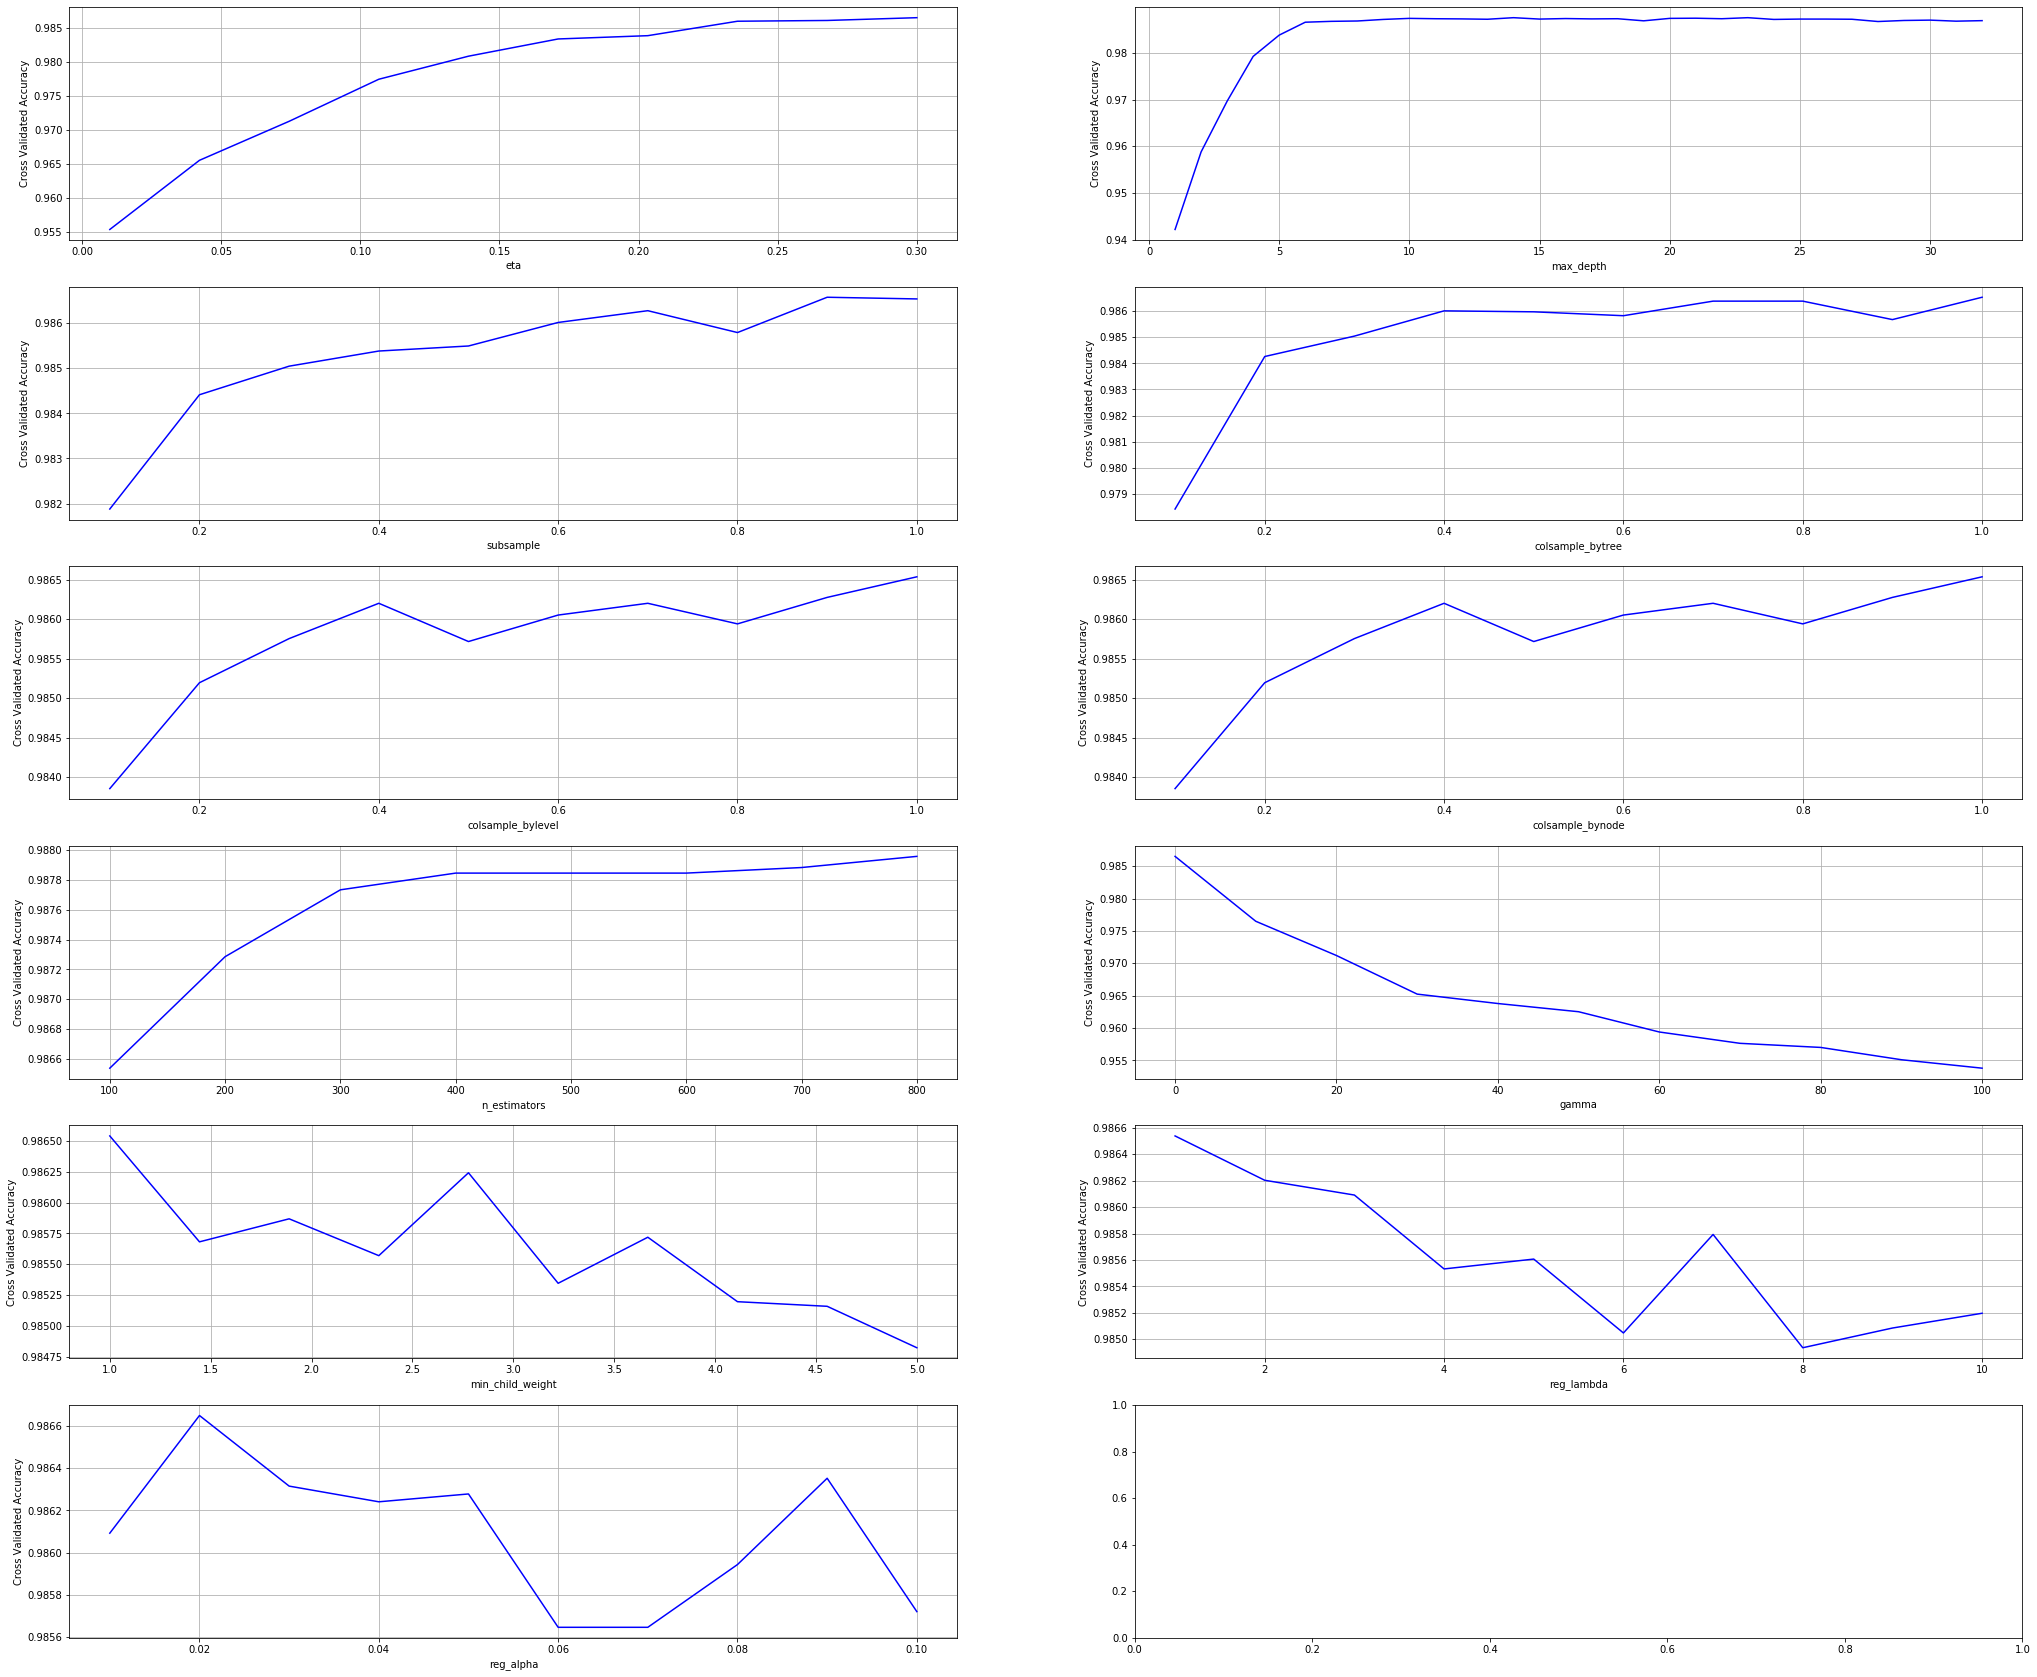

In [54]:
visualise_fold(fold_acc)

In [13]:
##smote_ENN

def compute_fold_acc_ENN(tunning_params):
    #auc_scores = []
    
    ##a=[]

    kf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
    #kf.get_n_splits(train_smote[x_var], train_smote[y_var])
    results = {}
    for feature in tqdm(tunning_params):
        accuracy = []
        for param in tunning_params[feature]:
            all_y_preds = []

            all_y_true = []
            
            for train_index, test_index in kf.split(train_smote[x_var], train_smote[y_var]):
                curr_train, curr_test = train_smote.iloc[train_index], train_smote.iloc[test_index]
                X_train = curr_train[x_var]
                y_train = curr_train[y_var]
                smote_only = SMOTE(random_state=1234, sampling_strategy=0.5)
                ennObj = EditedNearestNeighbours(n_neighbors=5)
                smote_enn = SMOTEENN(smote=smote_only , enn= ennObj)
                X_res_smote, y_res_smote = smote_enn.fit_resample(X_train, y_train)

                X_test = curr_test[x_var]
                y_test = curr_test[y_var]

                XG = XGBClassifier(**{feature:param}, random_state=1234, class_weight='balanced')
                XG.fit(X_res_smote, y_res_smote)
                y_preds = XG.predict(X_test)

                y_proba = XG.predict_proba(X_test)

                all_y_preds.extend(y_preds)

                all_y_true.extend(y_test)
            accuracy.append(accuracy_score(all_y_true, all_y_preds))
        results[feature]={'Accuracy':accuracy, feature: tunning_params[feature]}
    return results

                


   

In [16]:
try:
    fold_acc = load_file('Tuning/XG_fold_ENN.pkl')
except:
    fold_acc = compute_fold_acc_ENN(xg_tuning_params)
    save_file('Tuning/XG_fold_ENN.pkl', fold_acc)

  0%|                                                                                           | 0/11 [00:00<?, ?it/s]

[23:24:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:24:45] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:24:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in la

[23:27:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in la

[23:30:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:30] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in la

  9%|███████▎                                                                        | 1/11 [06:30<1:05:03, 390.37s/it]

[23:31:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:13] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in la

[23:33:02] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:33:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:33:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in la

[23:35:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:36:05] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:36:14] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in la

[23:39:11] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:39:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:39:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in la

[23:42:30] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:42:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:42:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in la

[23:45:45] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:45:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:46:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in la

[23:49:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:49:59] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:50:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in la

[23:53:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:53:13] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:53:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in la

 18%|██████████████▌                                                                 | 2/11 [29:24<1:42:49, 685.50s/it]

[23:54:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:54:08] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:54:14] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in la

[23:56:26] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:56:33] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:56:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in la

[23:59:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:59:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:59:32] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in la

 27%|█████████████████████▊                                                          | 3/11 [35:39<1:18:58, 592.36s/it]

[00:00:26] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:00:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:00:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in la

[00:05:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:05:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:05:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in la

[00:10:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:10:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:11:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in la

 36%|█████████████████████████████                                                   | 4/11 [47:22<1:12:58, 625.49s/it]

[00:12:08] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:12:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:12:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in la

[00:16:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:16:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in la

[00:21:26] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:21:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:21:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in la

 45%|████████████████████████████████████▎                                           | 5/11 [57:59<1:02:53, 628.89s/it]

[00:22:47] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:23:02] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:23:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in la

[00:27:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:27:35] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:27:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in la

[00:32:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:32:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:32:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in la

 55%|███████████████████████████████████████████▋                                    | 6/11 [1:08:41<52:44, 632.89s/it]

[00:33:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:33:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:33:56] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in la

[00:40:47] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:41:13] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:41:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in la

 64%|██████████████████████████████████████████████████▉                             | 7/11 [1:24:46<48:50, 732.55s/it]

[00:49:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:49:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:49:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in la

[00:55:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:55:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:55:45] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in la

[01:00:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:01:07] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:01:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in la

 73%|██████████████████████████████████████████████████████████▏                     | 8/11 [1:38:38<38:07, 762.46s/it]

[01:03:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:03:33] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:03:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in la

[01:07:55] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:08:07] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:08:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in la

[01:12:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:12:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:12:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in la

 82%|█████████████████████████████████████████████████████████████████▍              | 9/11 [1:48:48<23:53, 716.80s/it]

[01:13:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:13:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:13:55] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in la

[01:18:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:18:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:18:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in la

[01:22:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:22:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:23:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in la

 91%|███████████████████████████████████████████████████████████████████████▊       | 10/11 [1:59:11<11:28, 688.62s/it]

[01:23:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:24:06] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:24:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in la

[01:28:26] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:28:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:28:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in la

[01:33:00] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:33:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:33:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in la

100%|███████████████████████████████████████████████████████████████████████████████| 11/11 [2:09:33<00:00, 706.71s/it]


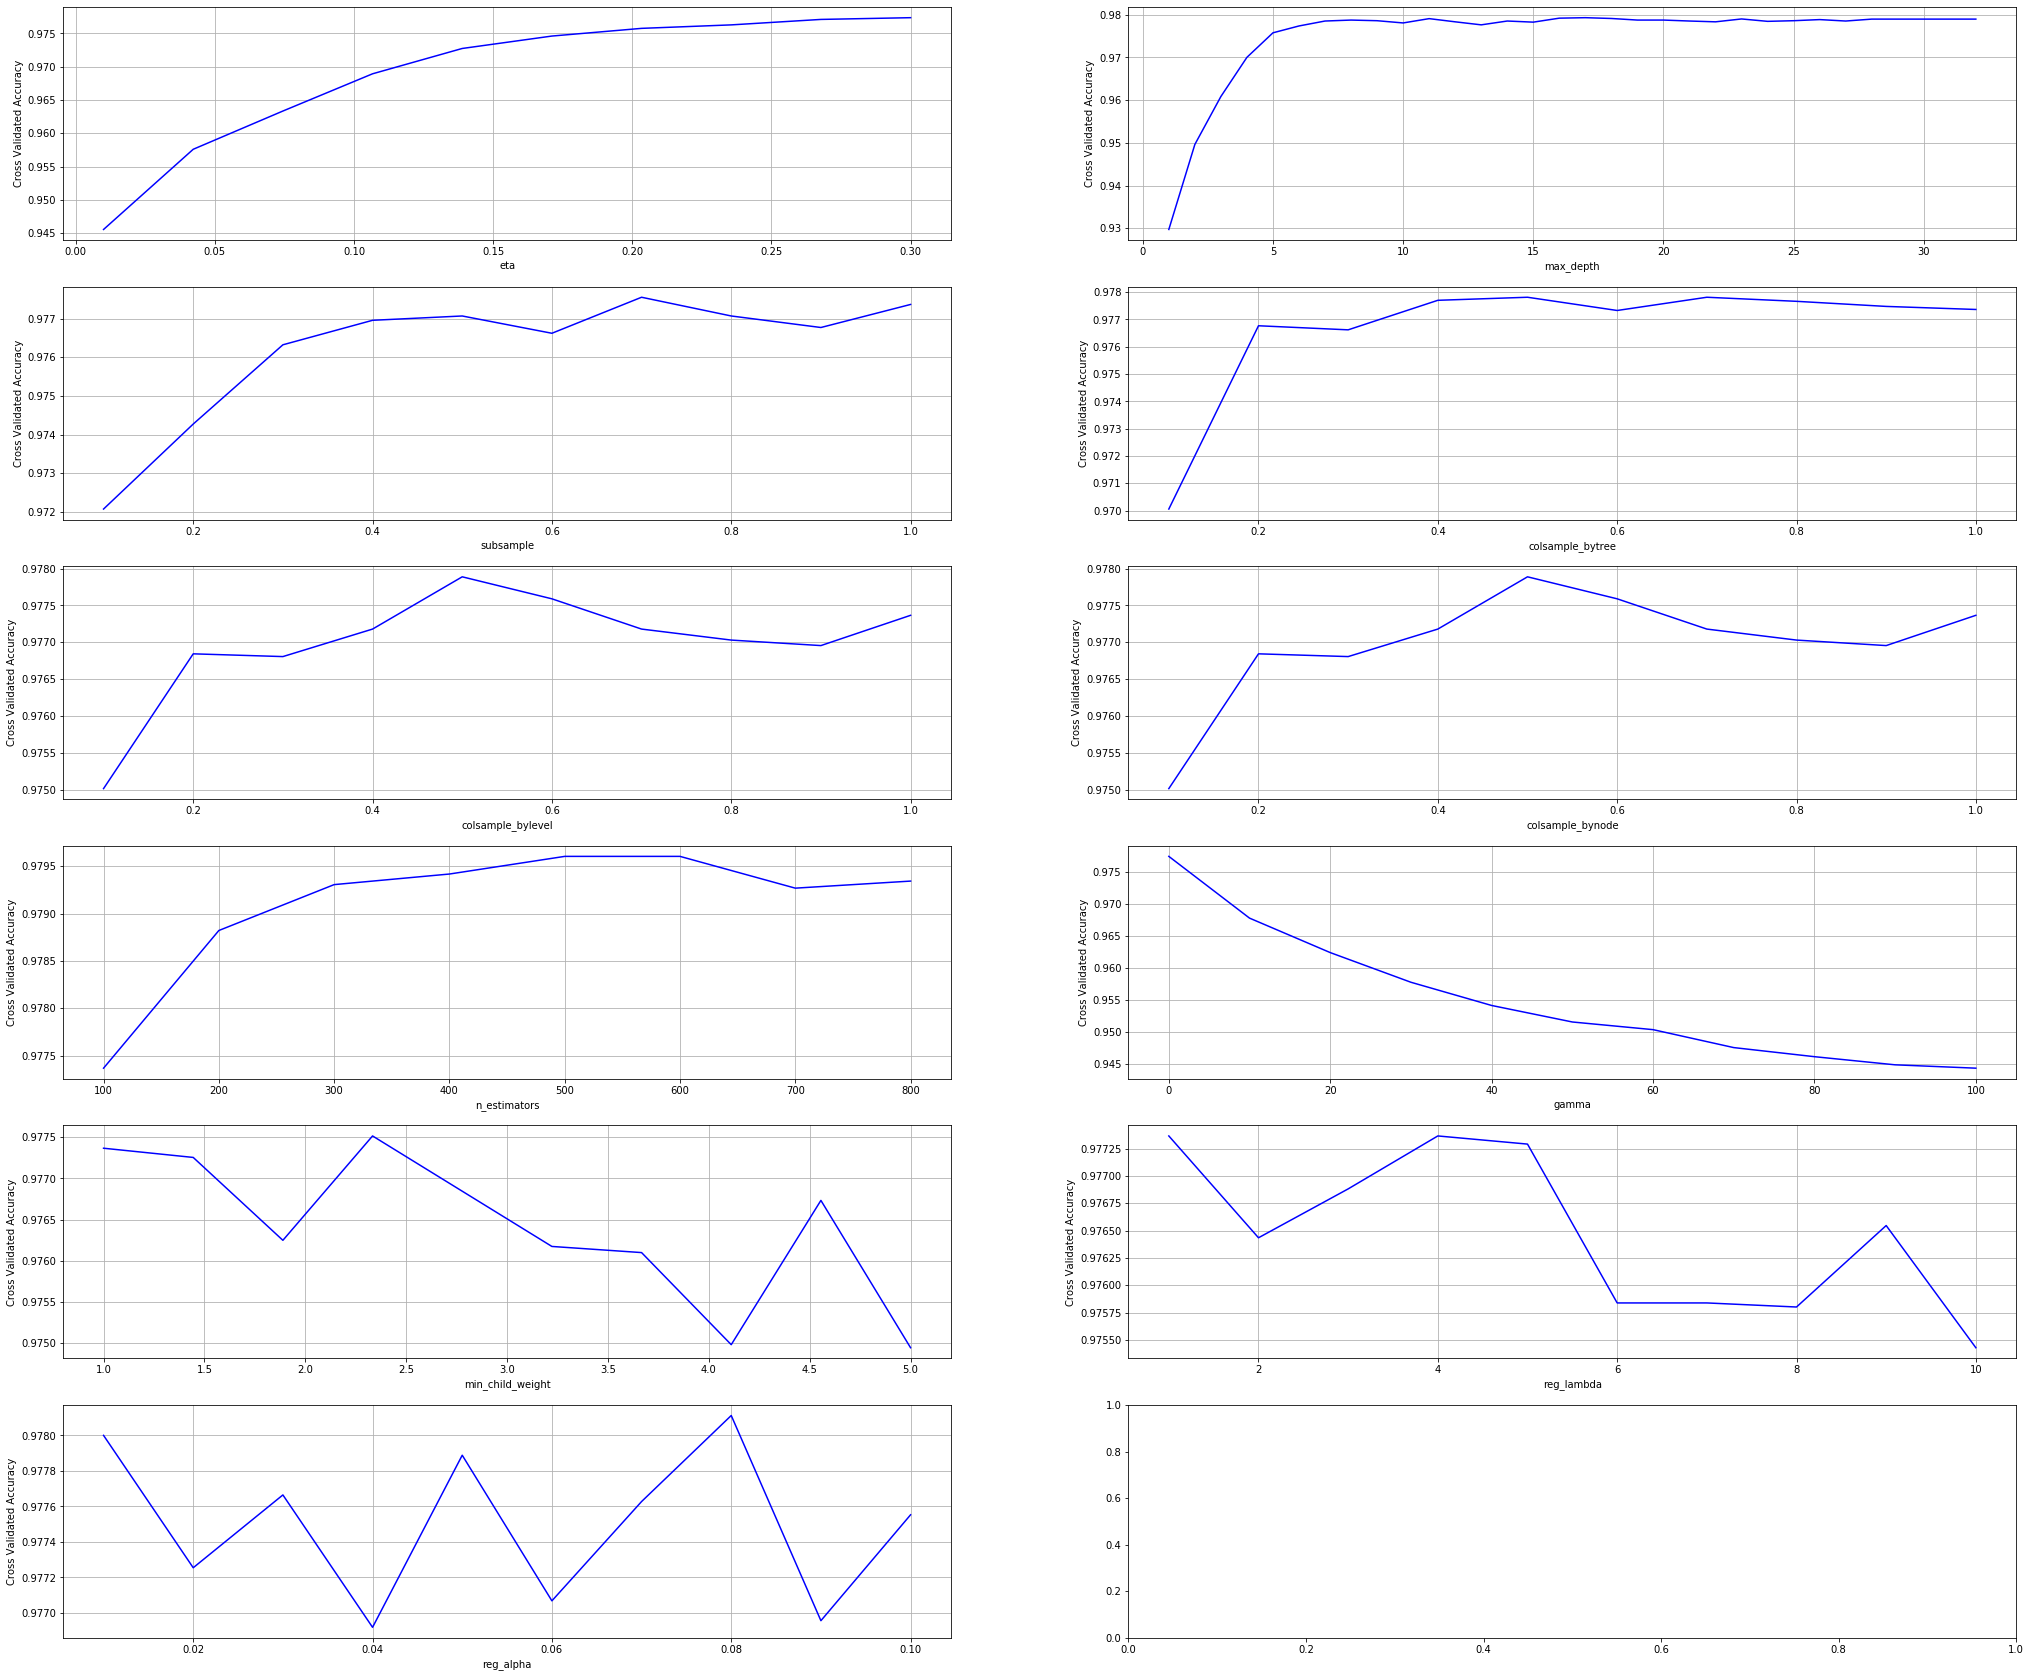

In [17]:
visualise_fold(fold_acc)

#### *Visualisation above did not help much in determinimg best parameters

# Baeysian optimization for 3 oversampling methods

In [180]:
def sortfile(x):
    df = pd.read_csv(x,header=0, names=['auc','result'])
    sort_by_auc = df.sort_values('auc')

    sort_by_auc.to_csv(x,index=False)

In [182]:

kf = StratifiedKFold(n_splits=5, random_state=1234, shuffle=False)
num_eval = 60

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [243]:
train4_new#dropping sic

x_var = [i for i in list(train4_new.columns) if i != 'bankrupt']
y_var = 'bankrupt'
import csv

In [267]:
#smote only method

def hyperopt(param_space, num_eval, out_file,use_scaling = False):  
    start = time()
    def objective_function(params):
        all_y_preds = []
        all_y_true = []
        kf = StratifiedKFold(n_splits=5, random_state=1, shuffle=False)
            
        for train_index, test_index in kf.split(train_smote[x_var], train_smote[y_var]):
            curr_train, curr_test = train_smote.iloc[train_index], train_smote.iloc[test_index]
            X_train = curr_train[x_var]
            y_train = curr_train[y_var]
            smote_only = SMOTE(random_state=1234, sampling_strategy=0.5)
            
            X_res_smote, y_res_smote = smote_only.fit_resample(X_train, y_train)

            X_test = curr_test[x_var]
            y_test = curr_test[y_var]

            XG = XGBClassifier(**params, random_state=1234)
            XG.fit(X_res_smote, y_res_smote)
            y_preds = XG.predict(X_test)

            y_proba = XG.predict_proba(X_test)
            all_y_proba.extend(y_proba[:, 1])

            all_y_preds.extend(y_preds)

            all_y_true.extend(y_test)
        fpr, tpr, _ = roc_curve(all_y_true, all_y_preds)
        auc1 =-1*auc(fpr, tpr)
        #auc=-1*roc_auc_score(all_y_true,all_y_proba)
      
        of_connection=open(out_file,'a')
        writer=csv.writer(of_connection)
        print([auc1,params])
        writer.writerow([auc1,params])
        return {'loss': auc1, 'status': STATUS_OK}
    trials = Trials()
    best_param = fmin(objective_function, param_space, algo=tpe.suggest, max_evals=num_eval, 
                      trials=trials, rstate= np.random.RandomState(1234))
    loss = [x['result']['loss'] for x in trials.trials] 
    best_param_values = best_param
    return trials, best_param_values

# Round1

In [268]:


out_file='output_smote.csv'
XGB_param_hyperopt = {
    'eta':hp.uniform('eta',0.01,0.1),
    'booster': hp.choice('booster', ['gbtree', 'gblinear']), 
    'max_depth': scope.int(hp.quniform('max_depth', 1, 10, 1)),
    'subsample': hp.uniform('subsample', 0.2, 0.9),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 0.9),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.1, 0.9),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.1, 0.9),
    'gamma': hp.uniform('gamma', 1, 10),
    'min_child_weight': hp.uniform('min_child_weight', 1.0, 10),
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 400, 10)),
    'reg_lambda': hp.uniform('reg_lambda', 1, 10),
    'reg_alpha':hp.uniform('reg_alpha', 0.01, 0.1)

}

try:
    XGB_hyperopt = load_file('Tuning/XGB_hyperopt_smote.pkl1')
except:
    XGB_hyperopt = hyperopt(XGB_param_hyperopt, num_eval,out_file)
    save_file('Tuning/XGB_hyperopt_smote.pkl1', XGB_hyperopt)

  0%|                                                                           | 0/60 [00:00<?, ?trial/s, best loss=?]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.803877566173692, {'booster': 'gbtree', 'colsample_bylevel': 0.188775016233022, 'colsample_bynode': 0.44835502044203546, 'colsample_bytree': 0.8800953373753237, 'eta': 0.07590400431460287, 'gamma': 6.106671720284223, 'max_depth': 3, 'min_child_weight': 3.7924367744956538, 'n_estimators': 360, 'reg_alpha': 0.01054700320236527, 'reg_lambda': 2.01747341928666, 'subsample': 0.7300264484674848}]
[13:19:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


  2%|▊                                                | 1/60 [00:18<18:00, 18.31s/trial, best loss: -0.8038

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[13:19:45] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:19:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:19:4

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[13:19:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:19:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:19:5

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[13:19:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:19:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:19:5

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8371988838277392, {'booster': 'gbtree', 'colsample_bylevel': 0.39756059884486106, 'colsample_bynode': 0.2955650176505742, 'colsample_bytree': 0.6447578789144355, 'eta': 0.034074793124941945, 'gamma': 5.0906111877626135, 'max_depth': 2, 'min_child_weight': 2.1093973285385417, 'n_estimators': 380, 'reg_alpha': 0.027624475157721172, 'reg_lambda': 3.7022600024248273, 'subsample': 0.8110224270834319}]
[13:20:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


  8%|████                                            | 5/60 [00:45<10:13, 11.16s/trial, best loss: -

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[13:20:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:20:13] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:20:1

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[13:20:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:20:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:20:1

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.794404537363854, {'booster': 'gbtree', 'colsample_bylevel': 0.6188675999947745, 'colsample_bynode': 0.31942243211173904, 'colsample_bytree': 0.4941302560570827, 'eta': 0.08592164649967034, 'gamma': 6.001144578478802, 'max_depth': 9, 'min_child_weight': 9.1714447599541, 'n_estimators': 120, 'reg_alpha': 0.04827675096634917, 'reg_lambda': 5.1769127482904675, 'subsample': 0.473737669397234}]
 13%|██████▍                                         | 8/60 [01:02<07:02,  8.12s/trial, best loss: -0.8371988838277392]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.7948925619903275, {'booster': 'gbtree', 'colsample_bylevel': 0.25997954893685016, 'colsample_bynode': 0.7033586087334864, 'colsample_bytree': 0.450799339337576, 'eta': 0.07880143953256827, 'gamma': 7.017965867468464, 'max_depth': 8, 'min_child_weight': 6.666929872176652, 'n_estimators': 210, 'reg_alpha': 0.08461262179854093, 'reg_lambda': 8.690917245952114, 'subsample': 0.5172369775533316}]
[13:20:47] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


 15%|███████▏                                        | 9/60 [01:20<09:34, 11.27s/trial, best loss: -0.8371

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[13:20:47] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:20:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:20:4

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.7703653319583746, {'booster': 'gbtree', 'colsample_bylevel': 0.12650176897218152, 'colsample_bynode': 0.4193696976745278, 'colsample_bytree': 0.8769811954708683, 'eta': 0.047440780888226994, 'gamma': 5.525335518611325, 'max_depth': 10, 'min_child_weight': 7.380739439980551, 'n_estimators': 400, 'reg_alpha': 0.02321860180598198, 'reg_lambda': 3.122863732353137, 'subsample': 0.29556720410648135}]
 18%|████████▌                                      | 11/60 [01:54<12:26, 15.23s/trial, best loss: -0.8371988838277392]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8093584581325478, {'booster': 'gbtree', 'colsample_bylevel': 0.29171246418178154, 'colsample_bynode': 0.41320755716285107, 'colsample_bytree': 0.3428400429335384, 'eta': 0.012023251055349463, 'gamma': 2.6752985346648037, 'max_depth': 4, 'min_child_weight': 1.4319792576420591, 'n_estimators': 150, 'reg_alpha': 0.017756108399945462, 'reg_lambda': 8.016593727317394, 'subsample': 0.743386321785839}]
 20%|█████████▍                                     | 12/60 [02:03<10:54, 13.64s/trial, best loss: -0.8371988838277392]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8361665240409684, {'booster': 'gbtree', 'colsample_bylevel': 0.26368170760847587, 'colsample_bynode': 0.2570075865579847, 'colsample_bytree': 0.522650925530696, 'eta': 0.01886281188910844, 'gamma': 7.9235355532475085, 'max_depth': 1, 'min_child_weight': 6.0618395587169225, 'n_estimators': 360, 'reg_alpha': 0.03965027096060138, 'reg_lambda': 6.206895689063276, 'subsample': 0.4741514832386742}]
 22%|██████████▏                                    | 13/60 [02:16<10:21, 13.21s/trial, best loss: -0.8371988838277392]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.833685645770861, {'booster': 'gbtree', 'colsample_bylevel': 0.14440102458351803, 'colsample_bynode': 0.5983608711134139, 'colsample_bytree': 0.5321958785657521, 'eta': 0.04315685067981016, 'gamma': 7.914275316043979, 'max_depth': 2, 'min_child_weight': 6.027848515051013, 'n_estimators': 350, 'reg_alpha': 0.07764421326589299, 'reg_lambda': 7.143616973670842, 'subsample': 0.8463127247585873}]
[13:21:59] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


 23%|██████████▉                                    | 14/60 [02:32<10:51, 14.16s/trial, best loss: -0.8371

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[13:21:59] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:22:00] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:22:0

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8349464624747847, {'booster': 'gbtree', 'colsample_bylevel': 0.19743632686060097, 'colsample_bynode': 0.8407756043858428, 'colsample_bytree': 0.5196005494072466, 'eta': 0.0746664031797251, 'gamma': 3.5985022731318987, 'max_depth': 1, 'min_child_weight': 8.203039195376064, 'n_estimators': 320, 'reg_alpha': 0.05987571361880961, 'reg_lambda': 1.3777804333284491, 'subsample': 0.7488840026445001}]
[13:22:13] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


 27%|████████████▌                                  | 16/60 [02:46<08:02, 10.97s/trial, best loss: -0.83

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[13:22:13] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:22:14] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:22:1

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8123118056330444, {'booster': 'gbtree', 'colsample_bylevel': 0.7749190590906684, 'colsample_bynode': 0.6258479588868794, 'colsample_bytree': 0.8988590147776575, 'eta': 0.01748178690058769, 'gamma': 9.562091334784665, 'max_depth': 9, 'min_child_weight': 3.795558999601517, 'n_estimators': 180, 'reg_alpha': 0.04226966744077996, 'reg_lambda': 3.392468515257821, 'subsample': 0.4601539433402015}]
 30%|██████████████                                 | 18/60 [03:05<07:34, 10.83s/trial, best loss: -0.8371988838277392]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8064024143633965, {'booster': 'gbtree', 'colsample_bylevel': 0.8180784937572247, 'colsample_bynode': 0.6074748010287715, 'colsample_bytree': 0.3981503500606842, 'eta': 0.08077453875587681, 'gamma': 2.744388129823696, 'max_depth': 9, 'min_child_weight': 1.7813740320607883, 'n_estimators': 140, 'reg_alpha': 0.04947658626035841, 'reg_lambda': 2.67216581089704, 'subsample': 0.24621122557898567}]
 32%|██████████████▉                                | 19/60 [03:15<07:14, 10.60s/trial, best loss: -0.8371988838277392]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8252229917879953, {'booster': 'gbtree', 'colsample_bylevel': 0.5875041666653975, 'colsample_bynode': 0.8296571683536124, 'colsample_bytree': 0.7669354798277415, 'eta': 0.013219179235237279, 'gamma': 1.1915041225159002, 'max_depth': 8, 'min_child_weight': 2.324379545154637, 'n_estimators': 100, 'reg_alpha': 0.03933792333999191, 'reg_lambda': 9.550451458166487, 'subsample': 0.6780270130299804}]
 33%|███████████████▋                               | 20/60 [03:25<06:55, 10.40s/trial, best loss: -0.8371988838277392]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8379716759051892, {'booster': 'gbtree', 'colsample_bylevel': 0.35873810878202167, 'colsample_bynode': 0.12435495604081129, 'colsample_bytree': 0.6491879860714006, 'eta': 0.03199911034917198, 'gamma': 9.034358093017746, 'max_depth': 1, 'min_child_weight': 4.917191931060651, 'n_estimators': 280, 'reg_alpha': 0.06550642944009784, 'reg_lambda': 7.0589902694333455, 'subsample': 0.6013784452051554}]
 35%|████████████████▍                              | 21/60 [03:35<06:39, 10.24s/trial, best loss: -0.8379716759051892]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8337419563046851, {'booster': 'gbtree', 'colsample_bylevel': 0.37604221360911977, 'colsample_bynode': 0.10453417612261115, 'colsample_bytree': 0.6664644713721184, 'eta': 0.031928226199312265, 'gamma': 9.58842467853632, 'max_depth': 2, 'min_child_weight': 4.727157433805639, 'n_estimators': 290, 'reg_alpha': 0.06481252481385284, 'reg_lambda': 6.379033709528032, 'subsample': 0.5916018883384978}]
 37%|█████████████████▏                             | 22/60 [03:48<07:02, 11.12s/trial, best loss: -0.8379716759051892]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8343801423546888, {'booster': 'gbtree', 'colsample_bylevel': 0.5337853263485771, 'colsample_bynode': 0.10328538754714578, 'colsample_bytree': 0.6305263394062611, 'eta': 0.052403837737211204, 'gamma': 8.92209090702518, 'max_depth': 2, 'min_child_weight': 5.005862707908896, 'n_estimators': 270, 'reg_alpha': 0.07062257151490683, 'reg_lambda': 4.222225613645818, 'subsample': 0.8201310264164253}]
 38%|██████████████████                             | 23/60 [04:01<07:06, 11.54s/trial, best loss: -0.8379716759051892]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8309950807615423, {'booster': 'gbtree', 'colsample_bylevel': 0.3576010919281116, 'colsample_bynode': 0.14903856185388373, 'colsample_bytree': 0.6851423576785711, 'eta': 0.0339425677235403, 'gamma': 4.777628201297228, 'max_depth': 4, 'min_child_weight': 1.1547028034717757, 'n_estimators': 210, 'reg_alpha': 0.0950586480947947, 'reg_lambda': 6.619151030089137, 'subsample': 0.8909646716090741}]
 40%|██████████████████▊                            | 24/60 [04:15<07:29, 12.48s/trial, best loss: -0.8379716759051892]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8354157169233168, {'booster': 'gbtree', 'colsample_bylevel': 0.6369439456677122, 'colsample_bynode': 0.32149407749577413, 'colsample_bytree': 0.5915825105195239, 'eta': 0.029187350168495968, 'gamma': 5.101177161399423, 'max_depth': 1, 'min_child_weight': 5.089902373382612, 'n_estimators': 390, 'reg_alpha': 0.06128921599066448, 'reg_lambda': 4.345888542418365, 'subsample': 0.6589673811819993}]
 42%|███████████████████▌                           | 25/60 [04:29<07:28, 12.81s/trial, best loss: -0.8379716759051892]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8247381819433792, {'booster': 'gbtree', 'colsample_bylevel': 0.49292985930237115, 'colsample_bynode': 0.34133368808327413, 'colsample_bytree': 0.7483041091707358, 'eta': 0.05800535741910383, 'gamma': 8.726016237979506, 'max_depth': 3, 'min_child_weight': 4.425289611555536, 'n_estimators': 290, 'reg_alpha': 0.0700543813077335, 'reg_lambda': 1.1304374214649897, 'subsample': 0.559402799884998}]
 43%|████████████████████▎                          | 26/60 [04:44<07:41, 13.56s/trial, best loss: -0.8379716759051892]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8256766908404436, {'booster': 'gbtree', 'colsample_bylevel': 0.3349907821928995, 'colsample_bynode': 0.1793147784998295, 'colsample_bytree': 0.7340655485129928, 'eta': 0.03557826517921453, 'gamma': 3.9326194718901184, 'max_depth': 4, 'min_child_weight': 9.940566082962164, 'n_estimators': 230, 'reg_alpha': 0.09954983051201695, 'reg_lambda': 7.243084559275302, 'subsample': 0.6759161347966388}]
 45%|█████████████████████▏                         | 27/60 [04:59<07:39, 13.93s/trial, best loss: -0.8379716759051892]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8336293352370373, {'booster': 'gbtree', 'colsample_bylevel': 0.22231454837853398, 'colsample_bynode': 0.1000388492681962, 'colsample_bytree': 0.5974267875327038, 'eta': 0.04479239789761271, 'gamma': 6.45634477288743, 'max_depth': 2, 'min_child_weight': 1.1626769749102857, 'n_estimators': 270, 'reg_alpha': 0.055821016961358924, 'reg_lambda': 4.951614394357519, 'subsample': 0.8814284763946191}]
 47%|█████████████████████▉                         | 28/60 [05:12<07:13, 13.54s/trial, best loss: -0.8379716759051892]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.7848751980201921, {'booster': 'gbtree', 'colsample_bylevel': 0.45785647536678287, 'colsample_bynode': 0.1519073749878124, 'colsample_bytree': 0.6856945556358757, 'eta': 0.050570869927232635, 'gamma': 8.545692878134552, 'max_depth': 5, 'min_child_weight': 3.9489385064919356, 'n_estimators': 390, 'reg_alpha': 0.07062869065662042, 'reg_lambda': 2.0051311312996907, 'subsample': 0.7108193777221722}]
 48%|██████████████████████▋                        | 29/60 [05:40<09:17, 17.98s/trial, best loss: -0.8379716759051892]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.832518679956644, {'booster': 'gbtree', 'colsample_bylevel': 0.6797214428322182, 'colsample_bynode': 0.3459088324319534, 'colsample_bytree': 0.8156984824934489, 'eta': 0.024705632797354098, 'gamma': 9.938012295062315, 'max_depth': 3, 'min_child_weight': 5.7299051466358755, 'n_estimators': 320, 'reg_alpha': 0.03169454011194337, 'reg_lambda': 6.050886155577248, 'subsample': 0.7931957238705648}]
 50%|███████████████████████▌                       | 30/60 [05:58<08:59, 17.98s/trial, best loss: -0.8379716759051892]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8351717046100802, {'booster': 'gbtree', 'colsample_bylevel': 0.4157694455167937, 'colsample_bynode': 0.5075299724641702, 'colsample_bytree': 0.5633695945828789, 'eta': 0.05848004032600518, 'gamma': 4.558331876173228, 'max_depth': 1, 'min_child_weight': 3.3242530705265625, 'n_estimators': 380, 'reg_alpha': 0.0221140581469305, 'reg_lambda': 1.9597644545641042, 'subsample': 0.6223381322884909}]
 52%|████████████████████████▎                      | 31/60 [06:11<08:00, 16.58s/trial, best loss: -0.8379716759051892]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8421418701900124, {'booster': 'gbtree', 'colsample_bylevel': 0.5267796794751416, 'colsample_bynode': 0.28628592024367916, 'colsample_bytree': 0.8122076573662993, 'eta': 0.03974031037815698, 'gamma': 5.416506053335699, 'max_depth': 2, 'min_child_weight': 2.588291344639156, 'n_estimators': 170, 'reg_alpha': 0.029820816362114408, 'reg_lambda': 5.742885857868932, 'subsample': 0.5736090602001546}]
 53%|█████████████████████████                      | 32/60 [06:19<06:29, 13.93s/trial, best loss: -0.8421418701900124]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8375555172086235, {'booster': 'gbtree', 'colsample_bylevel': 0.7355638574632788, 'colsample_bynode': 0.19796823428558422, 'colsample_bytree': 0.8172195056160729, 'eta': 0.039189509348132756, 'gamma': 3.3497378898859154, 'max_depth': 3, 'min_child_weight': 5.267618169067519, 'n_estimators': 180, 'reg_alpha': 0.0456112925477943, 'reg_lambda': 8.130790248312731, 'subsample': 0.5506102197183879}]
[13:25:55] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


 55%|█████████████████████████▊                     | 33/60 [06:29<05:41, 12.66s/trial, best loss: -0.84

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[13:25:56] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:25:56] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:25:5

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8386066471733356, {'booster': 'gbtree', 'colsample_bylevel': 0.876209500812928, 'colsample_bynode': 0.4805972420743505, 'colsample_bytree': 0.7833318997872558, 'eta': 0.04031049381677419, 'gamma': 6.366588587592494, 'max_depth': 1, 'min_child_weight': 6.494472034683827, 'n_estimators': 160, 'reg_alpha': 0.054419544261768434, 'reg_lambda': 9.884263139627507, 'subsample': 0.5183775717078516}]
[13:26:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


 58%|███████████████████████████▍                   | 35/60 [06:37<03:28,  8.35s/trial, best loss: -0.8421

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[13:26:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:26:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:26:0

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8380060014792144, {'booster': 'gbtree', 'colsample_bylevel': 0.8565803876402427, 'colsample_bynode': 0.5395673951796434, 'colsample_bytree': 0.898386070813997, 'eta': 0.056240071798629596, 'gamma': 4.213778526082189, 'max_depth': 4, 'min_child_weight': 7.776396444232373, 'n_estimators': 100, 'reg_alpha': 0.05347639789655718, 'reg_lambda': 9.893339416190877, 'subsample': 0.40940413525979524}]
[13:26:11] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


 62%|████████████████████████████▉                  | 37/60 [06:44<02:23,  6.24s/trial, best loss: -0.842

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[13:26:11] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:26:11] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:26:1

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8392855883610794, {'booster': 'gbtree', 'colsample_bylevel': 0.7903112432622867, 'colsample_bynode': 0.467877515316107, 'colsample_bytree': 0.8538488135824243, 'eta': 0.04921695117518077, 'gamma': 1.885169539875672, 'max_depth': 2, 'min_child_weight': 7.4669341579929505, 'n_estimators': 200, 'reg_alpha': 0.010946745756008899, 'reg_lambda': 5.777522792865749, 'subsample': 0.5151182362621411}]
 65%|██████████████████████████████▌                | 39/60 [06:55<02:06,  6.04s/trial, best loss: -0.8421418701900124]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8446039782821781, {'booster': 'gbtree', 'colsample_bylevel': 0.7983101742176067, 'colsample_bynode': 0.7615121339254604, 'colsample_bytree': 0.8519913048340231, 'eta': 0.049850259735786696, 'gamma': 1.3003485421784489, 'max_depth': 2, 'min_child_weight': 9.06163353204628, 'n_estimators': 210, 'reg_alpha': 0.011501286372062568, 'reg_lambda': 5.818079640452123, 'subsample': 0.26387892167563365}]
[13:26:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


 67%|███████████████████████████████▎               | 40/60 [07:03<02:12,  6.62s/trial, best loss: -0.8

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[13:26:30] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:26:30] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:26:3

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8038963363516333, {'booster': 'gbtree', 'colsample_bylevel': 0.7491686426081609, 'colsample_bynode': 0.8790765821555195, 'colsample_bytree': 0.47355739520548057, 'eta': 0.07087287247081156, 'gamma': 2.0088744555701394, 'max_depth': 6, 'min_child_weight': 9.734518422844786, 'n_estimators': 200, 'reg_alpha': 0.019894214677242616, 'reg_lambda': 5.001274752235776, 'subsample': 0.20082370891060852}]
 70%|████████████████████████████████▉              | 42/60 [07:16<02:05,  6.95s/trial, best loss: -0.8446039782821781]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8331756361845891, {'booster': 'gbtree', 'colsample_bylevel': 0.8333123427861273, 'colsample_bynode': 0.7682859734426251, 'colsample_bytree': 0.8633785346021863, 'eta': 0.0601097919173329, 'gamma': 2.3547718139781635, 'max_depth': 4, 'min_child_weight': 8.573736290651109, 'n_estimators': 130, 'reg_alpha': 0.025034913945730878, 'reg_lambda': 7.635219061550331, 'subsample': 0.21825418657897744}]
[13:26:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


 72%|█████████████████████████████████▋             | 43/60 [07:22<01:55,  6.81s/trial, best loss: -0.84

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[13:26:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:26:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:26:5

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8377619891659778, {'booster': 'gbtree', 'colsample_bylevel': 0.5137872353728901, 'colsample_bynode': 0.28191725762532144, 'colsample_bytree': 0.3954635418737478, 'eta': 0.025957245066122164, 'gamma': 1.497199467393156, 'max_depth': 2, 'min_child_weight': 7.118927485015419, 'n_estimators': 220, 'reg_alpha': 0.028562402722613386, 'reg_lambda': 4.568974620457296, 'subsample': 0.3606770336027254}]
 75%|███████████████████████████████████▎           | 45/60 [07:33<01:37,  6.52s/trial, best loss: -0.8446039782821781]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8154903952688367, {'booster': 'gbtree', 'colsample_bylevel': 0.7229224821657253, 'colsample_bynode': 0.36293010936181036, 'colsample_bytree': 0.7007348950334508, 'eta': 0.052696475164688346, 'gamma': 6.878409761757691, 'max_depth': 5, 'min_child_weight': 1.7665358212068893, 'n_estimators': 170, 'reg_alpha': 0.026557829729337387, 'reg_lambda': 2.598161269602606, 'subsample': 0.394219094557582}]
 77%|████████████████████████████████████           | 46/60 [07:44<01:49,  7.83s/trial, best loss: -0.8446039782821781]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8315426307036972, {'booster': 'gbtree', 'colsample_bylevel': 0.4448635665180567, 'colsample_bynode': 0.785511758348813, 'colsample_bytree': 0.6204605310218301, 'eta': 0.01956540852481925, 'gamma': 8.18895732376507, 'max_depth': 3, 'min_child_weight': 5.509936926575863, 'n_estimators': 260, 'reg_alpha': 0.02066059841706038, 'reg_lambda': 6.689553444070637, 'subsample': 0.3143101468940643}]
[13:27:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


 78%|████████████████████████████████████▊          | 47/60 [07:57<01:59,  9.21s/trial, best loss: -0.844603

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[13:27:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:27:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:27:2

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8355251232091072, {'booster': 'gbtree', 'colsample_bylevel': 0.6398509748273115, 'colsample_bynode': 0.43914951835505533, 'colsample_bytree': 0.5557182203367671, 'eta': 0.0415142871958708, 'gamma': 2.911733206630858, 'max_depth': 4, 'min_child_weight': 8.108226043378552, 'n_estimators': 110, 'reg_alpha': 0.04344186814741388, 'reg_lambda': 5.31596641100073, 'subsample': 0.4926379491673412}]
 82%|██████████████████████████████████████▍        | 49/60 [08:06<01:16,  6.99s/trial, best loss: -0.8446039782821781]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8424234228591316, {'booster': 'gbtree', 'colsample_bylevel': 0.59373325988877, 'colsample_bynode': 0.37946206667845656, 'colsample_bytree': 0.3405061526275346, 'eta': 0.03681810542520402, 'gamma': 3.941123640566117, 'max_depth': 1, 'min_child_weight': 6.187434424774615, 'n_estimators': 140, 'reg_alpha': 0.010544057565472508, 'reg_lambda': 4.791205707502222, 'subsample': 0.633224328185307}]
[13:27:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


 83%|███████████████████████████████████████▏       | 50/60 [08:11<01:05,  6.51s/trial, best loss: -0.84460

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[13:27:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:27:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:27:3

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8026918301815336, {'booster': 'gbtree', 'colsample_bylevel': 0.774683487554152, 'colsample_bynode': 0.38172956531549507, 'colsample_bytree': 0.15349114789893772, 'eta': 0.023188074062735566, 'gamma': 2.242362056598925, 'max_depth': 7, 'min_child_weight': 6.399551854770694, 'n_estimators': 130, 'reg_alpha': 0.03526252583288354, 'reg_lambda': 7.683064386491101, 'subsample': 0.7720281144243697}]
 87%|████████████████████████████████████████▋      | 52/60 [08:25<00:56,  7.09s/trial, best loss: -0.8446039782821781]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8465780617478705, {'booster': 'gbtree', 'colsample_bylevel': 0.6982389411691012, 'colsample_bynode': 0.5259133278816834, 'colsample_bytree': 0.215868042815267, 'eta': 0.07560892713480868, 'gamma': 1.5103557312310085, 'max_depth': 1, 'min_child_weight': 7.104620627870411, 'n_estimators': 150, 'reg_alpha': 0.01555778943650828, 'reg_lambda': 3.4251623509869114, 'subsample': 0.6313644726997234}]
 88%|█████████████████████████████████████████▌     | 53/60 [08:30<00:46,  6.64s/trial, best loss: -0.8465780617478705]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8053325142207431, {'booster': 'gbtree', 'colsample_bylevel': 0.7116972406243119, 'colsample_bynode': 0.5669774663359942, 'colsample_bytree': 0.22918018014936897, 'eta': 0.09006952138526855, 'gamma': 1.5061099259605868, 'max_depth': 6, 'min_child_weight': 7.159551828724133, 'n_estimators': 240, 'reg_alpha': 0.01645077100245973, 'reg_lambda': 1.4075716291397384, 'subsample': 0.85443863427491}]
 90%|██████████████████████████████████████████▎    | 54/60 [08:52<01:06, 11.07s/trial, best loss: -0.8465780617478705]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8098437864903666, {'booster': 'gbtree', 'colsample_bylevel': 0.8055134646777181, 'colsample_bynode': 0.6520743851428137, 'colsample_bytree': 0.10801127642934093, 'eta': 0.07491308077216317, 'gamma': 1.1744948572056169, 'max_depth': 10, 'min_child_weight': 7.85552180002284, 'n_estimators': 210, 'reg_alpha': 0.08400766105687679, 'reg_lambda': 2.2592494692071035, 'subsample': 0.6445224146018413}]
[13:28:40] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


 92%|███████████████████████████████████████████    | 55/60 [09:14<01:12, 14.45s/trial, best loss: -0.8

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[13:28:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:28:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:28:4

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8297219234433924, {'booster': 'gbtree', 'colsample_bylevel': 0.7070557574985306, 'colsample_bynode': 0.818928204554381, 'colsample_bytree': 0.1757215167725289, 'eta': 0.07890114066332324, 'gamma': 3.122645068268884, 'max_depth': 5, 'min_child_weight': 9.419074609166776, 'n_estimators': 110, 'reg_alpha': 0.07661968125085783, 'reg_lambda': 4.050732488092439, 'subsample': 0.2773926940719864}]
 95%|████████████████████████████████████████████▋  | 57/60 [09:21<00:27,  9.24s/trial, best loss: -0.8465780617478705]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8100314882697796, {'booster': 'gbtree', 'colsample_bylevel': 0.8415598099347421, 'colsample_bynode': 0.8671454714128977, 'colsample_bytree': 0.3690697944304614, 'eta': 0.09346432602343675, 'gamma': 2.4888846158261253, 'max_depth': 8, 'min_child_weight': 7.076441354949677, 'n_estimators': 310, 'reg_alpha': 0.04029058787860504, 'reg_lambda': 3.058751547059852, 'subsample': 0.7466901601225594}]
 97%|█████████████████████████████████████████████▍ | 58/60 [09:51<00:30, 15.39s/trial, best loss: -0.8465780617478705]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.843871941342468, {'booster': 'gbtree', 'colsample_bylevel': 0.6513673773277349, 'colsample_bynode': 0.6227526454937842, 'colsample_bytree': 0.2532999546959962, 'eta': 0.08520609455910982, 'gamma': 1.778119090565652, 'max_depth': 1, 'min_child_weight': 9.952805034307811, 'n_estimators': 340, 'reg_alpha': 0.024488496403857456, 'reg_lambda': 1.6823954311501197, 'subsample': 0.24432720125161506}]
 98%|██████████████████████████████████████████████▏| 59/60 [10:02<00:13, 13.89s/trial, best loss: -0.8465780617478705]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8466156021037533, {'booster': 'gbtree', 'colsample_bylevel': 0.6129880082650946, 'colsample_bynode': 0.5697764326031108, 'colsample_bytree': 0.3041599706217387, 'eta': 0.06239256460697985, 'gamma': 3.722299066134659, 'max_depth': 1, 'min_child_weight': 5.770318656530955, 'n_estimators': 220, 'reg_alpha': 0.035591182756136694, 'reg_lambda': 6.210160807218511, 'subsample': 0.6787478991493987}]
100%|███████████████████████████████████████████████| 60/60 [10:09<00:00, 10.17s/trial, best loss: -0.8466156021037533]


In [269]:
sortfile('output_smote.csv')

In [192]:

import csv

In [272]:
#smote and ENN

def hyperopt_enn(param_space, num_eval,out_file, use_scaling = False):  
    start = time()
    def objective_function(params):
        all_y_preds = []
        all_y_true = []
        kf = StratifiedKFold(n_splits=5, random_state=1, shuffle=False)
            
        for train_index, test_index in kf.split(train_smote[x_var], train_smote[y_var]):
            curr_train, curr_test = train_smote.iloc[train_index], train_smote.iloc[test_index]
            X_train = curr_train[x_var]
            y_train = curr_train[y_var]
            smote_only = SMOTE(random_state=1234, sampling_strategy=0.5)
            ennObj = EditedNearestNeighbours(n_neighbors=5)
            smote_enn = SMOTEENN(smote=smote_only , enn= ennObj)
            X_res_smoteENN, y_res_smoteENN = smote_enn.fit_resample(X_train, y_train)

            X_test = curr_test[x_var]
            y_test = curr_test[y_var]

            XG = XGBClassifier(**params, random_state=1234)
            XG.fit(X_res_smoteENN, y_res_smoteENN)
            y_preds = XG.predict(X_test)
            
            y_proba = XG.predict_proba(X_test)

            all_y_preds.extend(y_preds)
            all_y_proba.extend(y_proba[:, 1])

            all_y_true.extend(y_test)
        fpr, tpr, _ = roc_curve(all_y_true, all_y_preds)
        auc1 =-1*auc(fpr, tpr)
        of_connection=open(out_file,'a')
        writer=csv.writer(of_connection)
        print([auc1,params])
        writer.writerow([auc1,params])
        return {'loss': auc1, 'status': STATUS_OK}
    trials = Trials()
    best_param = fmin(objective_function, param_space, algo=tpe.suggest, max_evals=num_eval, 
                      trials=trials, rstate= np.random.RandomState(1234))
    loss = [x['result']['loss'] for x in trials.trials] 
    best_param_values = best_param
    return trials, best_param_values

# Round1

In [273]:
num_eval = 60

out_file='output_enn1.csv'
XGB_param_hyperopt = {
    'eta':hp.uniform('eta',0.01,0.1),
    'booster': hp.choice('booster', ['gbtree', 'gblinear']), 
    'max_depth': scope.int(hp.quniform('max_depth', 1, 10, 1)),
    'subsample': hp.uniform('subsample', 0.2, 0.9),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 0.9),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.1, 0.9),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.1, 0.9),
    'gamma': hp.uniform('gamma', 1, 10),
    'min_child_weight': hp.uniform('min_child_weight', 1.0, 10),
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 400, 10)),
    'reg_lambda': hp.uniform('reg_lambda', 1, 10),
    'reg_alpha':hp.uniform('reg_alpha', 0.01, 0.1)

}

try:
    XGB_hyperopt = load_file('Tuning/XGB_hyperopt_enn.pkl1')
except:
    XGB_hyperopt = hyperopt_enn(XGB_param_hyperopt, num_eval,out_file)
    save_file('Tuning/XGB_hyperopt_enn.pkl1', XGB_hyperopt)


  0%|                                                                           | 0/60 [00:00<?, ?trial/s, best loss=?]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8327128112997716, {'booster': 'gbtree', 'colsample_bylevel': 0.188775016233022, 'colsample_bynode': 0.44835502044203546, 'colsample_bytree': 0.8800953373753237, 'eta': 0.07590400431460287, 'gamma': 6.106671720284223, 'max_depth': 3, 'min_child_weight': 3.7924367744956538, 'n_estimators': 360, 'reg_alpha': 0.01054700320236527, 'reg_lambda': 2.01747341928666, 'subsample': 0.7300264484674848}]
  2%|▊                                               | 1/60 [00:16<16:21, 16.64s/trial, best loss: -0.8327128112997716]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[13:40:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:40:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:40:3

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[13:40:40] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:40:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:40:4

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[13:40:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:40:45] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:40:4

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8436906691267698, {'booster': 'gbtree', 'colsample_bylevel': 0.39756059884486106, 'colsample_bynode': 0.2955650176505742, 'colsample_bytree': 0.6447578789144355, 'eta': 0.034074793124941945, 'gamma': 5.0906111877626135, 'max_depth': 2, 'min_child_weight': 2.1093973285385417, 'n_estimators': 380, 'reg_alpha': 0.027624475157721172, 'reg_lambda': 3.7022600024248273, 'subsample': 0.8110224270834319}]
  8%|████                                            | 5/60 [00:47<10:33, 11.52s/trial, best loss: -0.8436906691267698]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[13:41:07] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:41:08] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:41:0

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[13:41:11] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:41:11] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:41:1

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.824951083464448, {'booster': 'gbtree', 'colsample_bylevel': 0.6188675999947745, 'colsample_bynode': 0.31942243211173904, 'colsample_bytree': 0.4941302560570827, 'eta': 0.08592164649967034, 'gamma': 6.001144578478802, 'max_depth': 9, 'min_child_weight': 9.1714447599541, 'n_estimators': 120, 'reg_alpha': 0.04827675096634917, 'reg_lambda': 5.1769127482904675, 'subsample': 0.473737669397234}]
 13%|██████▍                                         | 8/60 [01:06<07:35,  8.76s/trial, best loss: -0.8436906691267698]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8276947442257334, {'booster': 'gbtree', 'colsample_bylevel': 0.25997954893685016, 'colsample_bynode': 0.7033586087334864, 'colsample_bytree': 0.450799339337576, 'eta': 0.07880143953256827, 'gamma': 7.017965867468464, 'max_depth': 8, 'min_child_weight': 6.666929872176652, 'n_estimators': 210, 'reg_alpha': 0.08461262179854093, 'reg_lambda': 8.690917245952114, 'subsample': 0.5172369775533316}]
 15%|███████▏                                        | 9/60 [01:27<10:25, 12.27s/trial, best loss: -0.8436906691267698]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[13:41:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:41:47] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:41:4

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8212469288462998, {'booster': 'gbtree', 'colsample_bylevel': 0.12650176897218152, 'colsample_bynode': 0.4193696976745278, 'colsample_bytree': 0.8769811954708683, 'eta': 0.047440780888226994, 'gamma': 5.525335518611325, 'max_depth': 10, 'min_child_weight': 7.380739439980551, 'n_estimators': 400, 'reg_alpha': 0.02321860180598198, 'reg_lambda': 3.122863732353137, 'subsample': 0.29556720410648135}]
 18%|████████▌                                      | 11/60 [02:01<12:56, 15.84s/trial, best loss: -0.8436906691267698]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8158690136095197, {'booster': 'gbtree', 'colsample_bylevel': 0.29171246418178154, 'colsample_bynode': 0.41320755716285107, 'colsample_bytree': 0.3428400429335384, 'eta': 0.012023251055349463, 'gamma': 2.6752985346648037, 'max_depth': 4, 'min_child_weight': 1.4319792576420591, 'n_estimators': 150, 'reg_alpha': 0.017756108399945462, 'reg_lambda': 8.016593727317394, 'subsample': 0.743386321785839}]
 20%|█████████▍                                     | 12/60 [02:12<11:30, 14.38s/trial, best loss: -0.8436906691267698]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8462434133267849, {'booster': 'gbtree', 'colsample_bylevel': 0.26368170760847587, 'colsample_bynode': 0.2570075865579847, 'colsample_bytree': 0.522650925530696, 'eta': 0.01886281188910844, 'gamma': 7.9235355532475085, 'max_depth': 1, 'min_child_weight': 6.0618395587169225, 'n_estimators': 360, 'reg_alpha': 0.03965027096060138, 'reg_lambda': 6.206895689063276, 'subsample': 0.4741514832386742}]
 22%|██████████▏                                    | 13/60 [02:26<11:03, 14.11s/trial, best loss: -0.8462434133267849]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8408719276537193, {'booster': 'gbtree', 'colsample_bylevel': 0.14440102458351803, 'colsample_bynode': 0.5983608711134139, 'colsample_bytree': 0.5321958785657521, 'eta': 0.04315685067981016, 'gamma': 7.914275316043979, 'max_depth': 2, 'min_child_weight': 6.027848515051013, 'n_estimators': 350, 'reg_alpha': 0.07764421326589299, 'reg_lambda': 7.143616973670842, 'subsample': 0.8463127247585873}]
 23%|██████████▉                                    | 14/60 [02:43<11:29, 15.00s/trial, best loss: -0.8462434133267849]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[13:43:02] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:43:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:43:0

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8402900521375395, {'booster': 'gbtree', 'colsample_bylevel': 0.19743632686060097, 'colsample_bynode': 0.8407756043858428, 'colsample_bytree': 0.5196005494072466, 'eta': 0.0746664031797251, 'gamma': 3.5985022731318987, 'max_depth': 1, 'min_child_weight': 8.203039195376064, 'n_estimators': 320, 'reg_alpha': 0.05987571361880961, 'reg_lambda': 1.3777804333284491, 'subsample': 0.7488840026445001}]
 27%|████████████▌                                  | 16/60 [02:59<08:43, 11.89s/trial, best loss: -0.8462434133267849]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[13:43:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:43:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:43:2

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8444913572145305, {'booster': 'gbtree', 'colsample_bylevel': 0.7749190590906684, 'colsample_bynode': 0.6258479588868794, 'colsample_bytree': 0.8988590147776575, 'eta': 0.01748178690058769, 'gamma': 9.562091334784665, 'max_depth': 9, 'min_child_weight': 3.795558999601517, 'n_estimators': 180, 'reg_alpha': 0.04226966744077996, 'reg_lambda': 3.392468515257821, 'subsample': 0.4601539433402015}]
 30%|██████████████                                 | 18/60 [03:20<08:16, 11.83s/trial, best loss: -0.8462434133267849]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8323438373046605, {'booster': 'gbtree', 'colsample_bylevel': 0.8180784937572247, 'colsample_bynode': 0.6074748010287715, 'colsample_bytree': 0.3981503500606842, 'eta': 0.08077453875587681, 'gamma': 2.744388129823696, 'max_depth': 9, 'min_child_weight': 1.7813740320607883, 'n_estimators': 140, 'reg_alpha': 0.04947658626035841, 'reg_lambda': 2.67216581089704, 'subsample': 0.24621122557898567}]
 32%|██████████████▉                                | 19/60 [03:31<07:58, 11.66s/trial, best loss: -0.8462434133267849]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8333102422120354, {'booster': 'gbtree', 'colsample_bylevel': 0.5875041666653975, 'colsample_bynode': 0.8296571683536124, 'colsample_bytree': 0.7669354798277415, 'eta': 0.013219179235237279, 'gamma': 1.1915041225159002, 'max_depth': 8, 'min_child_weight': 2.324379545154637, 'n_estimators': 100, 'reg_alpha': 0.03933792333999191, 'reg_lambda': 9.550451458166487, 'subsample': 0.6780270130299804}]
 33%|███████████████▋                               | 20/60 [03:43<07:45, 11.63s/trial, best loss: -0.8462434133267849]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8425204885306954, {'booster': 'gbtree', 'colsample_bylevel': 0.8703423133356305, 'colsample_bynode': 0.10614181270117651, 'colsample_bytree': 0.7009977365621004, 'eta': 0.02191535661769163, 'gamma': 9.727937948218939, 'max_depth': 5, 'min_child_weight': 5.1050206935262175, 'n_estimators': 190, 'reg_alpha': 0.06426915501359827, 'reg_lambda': 6.561234773876735, 'subsample': 0.6173433901329493}]
 35%|████████████████▍                              | 21/60 [03:58<08:19, 12.80s/trial, best loss: -0.8462434133267849]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8281452284963242, {'booster': 'gbtree', 'colsample_bylevel': 0.7778962585690657, 'colsample_bynode': 0.7097659213848192, 'colsample_bytree': 0.5826857269832317, 'eta': 0.031104974704420904, 'gamma': 9.97814494876475, 'max_depth': 7, 'min_child_weight': 4.629005765506092, 'n_estimators': 280, 'reg_alpha': 0.03954332301534306, 'reg_lambda': 6.379033709528032, 'subsample': 0.6005624672952601}]
 37%|█████████████████▏                             | 22/60 [04:23<10:23, 16.41s/trial, best loss: -0.8462434133267849]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8442693298610924, {'booster': 'gbtree', 'colsample_bylevel': 0.696286624478615, 'colsample_bynode': 0.1693333306097027, 'colsample_bytree': 0.6972887620835315, 'eta': 0.016590187186036363, 'gamma': 8.723651428453886, 'max_depth': 4, 'min_child_weight': 5.609433306363997, 'n_estimators': 180, 'reg_alpha': 0.06569413771932942, 'reg_lambda': 4.442702020404113, 'subsample': 0.2560183944931902}]
 38%|██████████████████                             | 23/60 [04:33<08:55, 14.47s/trial, best loss: -0.8462434133267849]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8317335472649674, {'booster': 'gbtree', 'colsample_bylevel': 0.34741515168259285, 'colsample_bynode': 0.10788462860292966, 'colsample_bytree': 0.5986157634861458, 'eta': 0.010606798432007737, 'gamma': 8.992083845114005, 'max_depth': 1, 'min_child_weight': 4.975515259584866, 'n_estimators': 240, 'reg_alpha': 0.041585681399160655, 'reg_lambda': 6.202037344514452, 'subsample': 0.5548460060884578}]
 40%|██████████████████▊                            | 24/60 [04:43<07:51, 13.10s/trial, best loss: -0.8462434133267849]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8327128112997716, {'booster': 'gbtree', 'colsample_bylevel': 0.5177197130016774, 'colsample_bynode': 0.3475908611951472, 'colsample_bytree': 0.7529185082554558, 'eta': 0.05185283396009758, 'gamma': 8.546173169924634, 'max_depth': 7, 'min_child_weight': 4.136504888479066, 'n_estimators': 270, 'reg_alpha': 0.034169750810658595, 'reg_lambda': 4.469141025294055, 'subsample': 0.2040427794015316}]
 42%|███████████████████▌                           | 25/60 [05:00<08:19, 14.26s/trial, best loss: -0.8462434133267849]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8342771656326131, {'booster': 'gbtree', 'colsample_bylevel': 0.8814770418300404, 'colsample_bynode': 0.5206285153809166, 'colsample_bytree': 0.19203492584410414, 'eta': 0.03573599342679705, 'gamma': 9.463010830642839, 'max_depth': 4, 'min_child_weight': 5.949508545893062, 'n_estimators': 210, 'reg_alpha': 0.05785820899088415, 'reg_lambda': 1.153778973796416, 'subsample': 0.4133839714529297}]
 43%|████████████████████▎                          | 26/60 [05:14<07:57, 14.04s/trial, best loss: -0.8462434133267849]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.832428043848795, {'booster': 'gbtree', 'colsample_bylevel': 0.6573772458741527, 'colsample_bynode': 0.6498088802472717, 'colsample_bytree': 0.3121296299576821, 'eta': 0.01939815671796307, 'gamma': 8.598729290487768, 'max_depth': 2, 'min_child_weight': 3.6108283343819343, 'n_estimators': 160, 'reg_alpha': 0.04553354021361235, 'reg_lambda': 7.269821620516634, 'subsample': 0.5617323651274901}]
 45%|█████████████████████▏                         | 27/60 [05:22<06:48, 12.38s/trial, best loss: -0.8462434133267849]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8373522600331268, {'booster': 'gbtree', 'colsample_bylevel': 0.509646588533779, 'colsample_bynode': 0.8852832371277402, 'colsample_bytree': 0.8014941067807789, 'eta': 0.02630234638418492, 'gamma': 8.267352597034739, 'max_depth': 10, 'min_child_weight': 6.545665372281511, 'n_estimators': 220, 'reg_alpha': 0.07309545346011867, 'reg_lambda': 5.748196581651381, 'subsample': 0.3370893997864574}]
 47%|█████████████████████▉                         | 28/60 [05:41<07:35, 14.24s/trial, best loss: -0.8462434133267849]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8451547430061902, {'booster': 'gbtree', 'colsample_bylevel': 0.20980475377443122, 'colsample_bynode': 0.7721112400842955, 'colsample_bytree': 0.6536269732689861, 'eta': 0.062071593910214454, 'gamma': 6.48656415893781, 'max_depth': 3, 'min_child_weight': 9.976475143024071, 'n_estimators': 110, 'reg_alpha': 0.022017431155921557, 'reg_lambda': 1.6953396441326842, 'subsample': 0.4480487263759194}]
 48%|██████████████████████▋                        | 29/60 [05:48<06:19, 12.23s/trial, best loss: -0.8462434133267849]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8400052846865629, {'booster': 'gbtree', 'colsample_bylevel': 0.23014672369531539, 'colsample_bynode': 0.7621062022563647, 'colsample_bytree': 0.6334692863951508, 'eta': 0.061049708588445, 'gamma': 6.665455276613578, 'max_depth': 3, 'min_child_weight': 9.788007889415525, 'n_estimators': 110, 'reg_alpha': 0.01999031037286899, 'reg_lambda': 1.4230121164716856, 'subsample': 0.6748837955479567}]
 50%|███████████████████████▌                       | 30/60 [05:56<05:27, 10.91s/trial, best loss: -0.8462434133267849]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8510582232253264, {'booster': 'gbtree', 'colsample_bylevel': 0.36282317653680374, 'colsample_bynode': 0.5106712200771683, 'colsample_bytree': 0.5659407732779239, 'eta': 0.07203847236193418, 'gamma': 4.86495727945691, 'max_depth': 1, 'min_child_weight': 9.772945987708567, 'n_estimators': 300, 'reg_alpha': 0.09806791658617107, 'reg_lambda': 2.1450174743961874, 'subsample': 0.3137109610931694}]
 52%|████████████████████████▎                      | 31/60 [06:07<05:16, 10.91s/trial, best loss: -0.8510582232253264]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8481268606846282, {'booster': 'gbtree', 'colsample_bylevel': 0.34972613101007943, 'colsample_bynode': 0.5077115431267478, 'colsample_bytree': 0.4634273673467489, 'eta': 0.07232434971990304, 'gamma': 4.348985691753791, 'max_depth': 1, 'min_child_weight': 8.837798820970416, 'n_estimators': 320, 'reg_alpha': 0.09631589136755497, 'reg_lambda': 2.360098405293245, 'subsample': 0.2190723930683418}]
 53%|█████████████████████████                      | 32/60 [06:19<05:11, 11.11s/trial, best loss: -0.8510582232253264]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8431463339664724, {'booster': 'gbtree', 'colsample_bylevel': 0.36481643494002464, 'colsample_bynode': 0.4815344775454746, 'colsample_bytree': 0.42140905706505416, 'eta': 0.07057889832982649, 'gamma': 4.298346294155275, 'max_depth': 2, 'min_child_weight': 9.20117584988122, 'n_estimators': 300, 'reg_alpha': 0.09856451739989777, 'reg_lambda': 2.193893337272114, 'subsample': 0.22934110218148782}]
 55%|█████████████████████████▊                     | 33/60 [06:31<05:12, 11.58s/trial, best loss: -0.8510582232253264]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[13:46:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:46:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:46:5

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8290869521752459, {'booster': 'gbtree', 'colsample_bylevel': 0.39695621029606565, 'colsample_bynode': 0.3644971785884372, 'colsample_bytree': 0.5713219786554764, 'eta': 0.09418663445910522, 'gamma': 3.3804914179490293, 'max_depth': 3, 'min_child_weight': 7.595618643160739, 'n_estimators': 380, 'reg_alpha': 0.09521105718166678, 'reg_lambda': 2.417707513283249, 'subsample': 0.3073847764086079}]
 58%|███████████████████████████▍                   | 35/60 [06:55<05:09, 12.39s/trial, best loss: -0.8510582232253264]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[13:47:14] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:47:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:47:1

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8455896718806971, {'booster': 'gbtree', 'colsample_bylevel': 0.35234974335600017, 'colsample_bynode': 0.660594339795625, 'colsample_bytree': 0.2421678788117207, 'eta': 0.09959461224244927, 'gamma': 1.9557555775529472, 'max_depth': 1, 'min_child_weight': 7.7705316758103375, 'n_estimators': 260, 'reg_alpha': 0.07272442602152326, 'reg_lambda': 1.0688421712351317, 'subsample': 0.39518684029108403}]
 62%|████████████████████████████▉                  | 37/60 [07:09<03:47,  9.90s/trial, best loss: -0.8510582232253264]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[13:47:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:47:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:47:3

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8461903175748184, {'booster': 'gbtree', 'colsample_bylevel': 0.5538145701159453, 'colsample_bynode': 0.45837557499700665, 'colsample_bytree': 0.6985067435118995, 'eta': 0.05492337108259827, 'gamma': 3.7869890194372973, 'max_depth': 2, 'min_child_weight': 9.719085500675064, 'n_estimators': 390, 'reg_alpha': 0.08215583331615282, 'reg_lambda': 3.709115570672867, 'subsample': 0.20027356131500532}]
 65%|██████████████████████████████▌                | 39/60 [07:28<03:37, 10.34s/trial, best loss: -0.8510582232253264]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8115706428609649, {'booster': 'gbtree', 'colsample_bylevel': 0.42497706014245573, 'colsample_bynode': 0.30758665627928283, 'colsample_bytree': 0.5543381841517507, 'eta': 0.07471635964464395, 'gamma': 5.5543834141615624, 'max_depth': 5, 'min_child_weight': 7.280579617581333, 'n_estimators': 310, 'reg_alpha': 0.0947833030964475, 'reg_lambda': 1.8242051870310698, 'subsample': 0.5201764675687429}]
 67%|███████████████████████████████▎               | 40/60 [07:50<04:32, 13.61s/trial, best loss: -0.8510582232253264]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[13:48:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:48:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:48:1

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8374150001306653, {'booster': 'gbtree', 'colsample_bylevel': 0.2450684709149918, 'colsample_bynode': 0.3750639411252904, 'colsample_bytree': 0.4932190892468052, 'eta': 0.09168345552063772, 'gamma': 1.7533893650151464, 'max_depth': 2, 'min_child_weight': 7.89653830204382, 'n_estimators': 280, 'reg_alpha': 0.08663883994218126, 'reg_lambda': 3.091295565059548, 'subsample': 0.32390502217673656}]
 70%|████████████████████████████████▉              | 42/60 [08:06<03:23, 11.33s/trial, best loss: -0.8510582232253264]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8344868523718246, {'booster': 'gbtree', 'colsample_bylevel': 0.3777184688812005, 'colsample_bynode': 0.49091836924121074, 'colsample_bytree': 0.30939950374885505, 'eta': 0.08791353225366838, 'gamma': 4.610880673382036, 'max_depth': 3, 'min_child_weight': 8.740919213553223, 'n_estimators': 370, 'reg_alpha': 0.06727388818764565, 'reg_lambda': 3.6380896199139183, 'subsample': 0.3688999470865809}]
 72%|█████████████████████████████████▋             | 43/60 [08:24<03:45, 13.24s/trial, best loss: -0.8510582232253264]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[13:48:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:48:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:48:4

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8374117853488081, {'booster': 'gbtree', 'colsample_bylevel': 0.2764763025412987, 'colsample_bynode': 0.4237990008108419, 'colsample_bytree': 0.4630964596854834, 'eta': 0.04814545769226965, 'gamma': 2.2590058972796276, 'max_depth': 4, 'min_child_weight': 8.981791874623825, 'n_estimators': 250, 'reg_alpha': 0.09686729673163998, 'reg_lambda': 4.927202239609969, 'subsample': 0.27040509325370904}]
 75%|███████████████████████████████████▎           | 45/60 [08:41<02:48, 11.24s/trial, best loss: -0.8510582232253264]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8240656703193502, {'booster': 'gbtree', 'colsample_bylevel': 0.3267042922110393, 'colsample_bynode': 0.2791862279022342, 'colsample_bytree': 0.639376642542131, 'eta': 0.07858782237301784, 'gamma': 4.061601854530093, 'max_depth': 6, 'min_child_weight': 6.419435208736163, 'n_estimators': 230, 'reg_alpha': 0.09096173838180233, 'reg_lambda': 3.8776430794588466, 'subsample': 0.509731110533102}]
 77%|████████████████████████████████████           | 46/60 [09:00<03:09, 13.54s/trial, best loss: -0.8510582232253264]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8373243640228162, {'booster': 'gbtree', 'colsample_bylevel': 0.1650687819095041, 'colsample_bynode': 0.6721911805838698, 'colsample_bytree': 0.16248310998116794, 'eta': 0.08511652480446302, 'gamma': 6.081952032801427, 'max_depth': 3, 'min_child_weight': 8.429129477159156, 'n_estimators': 340, 'reg_alpha': 0.08333116911668258, 'reg_lambda': 3.3004622908084977, 'subsample': 0.3841006378664379}]
 78%|████████████████████████████████████▊          | 47/60 [09:18<03:11, 14.73s/trial, best loss: -0.8510582232253264]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[13:49:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:49:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:49:3

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.818506482866872, {'booster': 'gbtree', 'colsample_bylevel': 0.1144728723172164, 'colsample_bynode': 0.15442661529825186, 'colsample_bytree': 0.49371595119283807, 'eta': 0.06522214151935864, 'gamma': 3.125772739498931, 'max_depth': 5, 'min_child_weight': 9.613462843756302, 'n_estimators': 400, 'reg_alpha': 0.0608541380185055, 'reg_lambda': 1.6252846254294664, 'subsample': 0.2261155558687466}]
 82%|██████████████████████████████████████▍        | 49/60 [09:42<02:37, 14.33s/trial, best loss: -0.8510582232253264]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8463029386424661, {'booster': 'gbtree', 'colsample_bylevel': 0.617037368600839, 'colsample_bynode': 0.6023290694319081, 'colsample_bytree': 0.8422376391124571, 'eta': 0.04292762209042658, 'gamma': 5.365372817952169, 'max_depth': 2, 'min_child_weight': 8.76549137367802, 'n_estimators': 350, 'reg_alpha': 0.05234630343329622, 'reg_lambda': 2.471715864630426, 'subsample': 0.34333484040359985}]
 83%|███████████████████████████████████████▏       | 50/60 [09:57<02:23, 14.32s/trial, best loss: -0.8510582232253264]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[13:50:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:50:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:50:1

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8408343872978369, {'booster': 'gbtree', 'colsample_bylevel': 0.1006417157020233, 'colsample_bynode': 0.3434195878358334, 'colsample_bytree': 0.6684604194273367, 'eta': 0.0787460639731762, 'gamma': 5.691537775324111, 'max_depth': 2, 'min_child_weight': 8.146120594671254, 'n_estimators': 310, 'reg_alpha': 0.07586245058767907, 'reg_lambda': 2.8231336476205495, 'subsample': 0.41055663248316915}]
 87%|████████████████████████████████████████▋      | 52/60 [10:15<01:35, 11.98s/trial, best loss: -0.8510582232253264]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8321840315355582, {'booster': 'gbtree', 'colsample_bylevel': 0.39369236646528827, 'colsample_bynode': 0.39801674575081836, 'colsample_bytree': 0.7415452454630083, 'eta': 0.05361018150857138, 'gamma': 7.0918695462451184, 'max_depth': 7, 'min_child_weight': 7.400407134718348, 'n_estimators': 200, 'reg_alpha': 0.010457089447074061, 'reg_lambda': 7.100576280981385, 'subsample': 0.6791536514990709}]
 88%|█████████████████████████████████████████▌     | 53/60 [10:33<01:36, 13.77s/trial, best loss: -0.8510582232253264]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8323626074826018, {'booster': 'gbtree', 'colsample_bylevel': 0.2935419403721125, 'colsample_bynode': 0.5161082498659916, 'colsample_bytree': 0.3301838609820664, 'eta': 0.07184556175541817, 'gamma': 5.153872443133306, 'max_depth': 4, 'min_child_weight': 5.355107901098605, 'n_estimators': 290, 'reg_alpha': 0.09316909144983061, 'reg_lambda': 1.9881198287783417, 'subsample': 0.31335048983961655}]
 90%|██████████████████████████████████████████▎    | 54/60 [10:48<01:24, 14.13s/trial, best loss: -0.8510582232253264]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8292247729845496, {'booster': 'gbtree', 'colsample_bylevel': 0.3256008452091328, 'colsample_bynode': 0.8098689426733148, 'colsample_bytree': 0.395971240571828, 'eta': 0.05089896970533478, 'gamma': 4.789283407543199, 'max_depth': 5, 'min_child_weight': 7.8959019834805355, 'n_estimators': 320, 'reg_alpha': 0.028074732955146006, 'reg_lambda': 4.139099241519708, 'subsample': 0.7930426365195413}]
 92%|███████████████████████████████████████████    | 55/60 [11:11<01:24, 16.91s/trial, best loss: -0.8510582232253264]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[13:51:30] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:51:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:51:3

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8427709304076468, {'booster': 'gbtree', 'colsample_bylevel': 0.1486141510185204, 'colsample_bynode': 0.68900357836934, 'colsample_bytree': 0.7343931237470184, 'eta': 0.08261047410616942, 'gamma': 4.086119481710382, 'max_depth': 1, 'min_child_weight': 4.634190690645454, 'n_estimators': 340, 'reg_alpha': 0.07916678342249914, 'reg_lambda': 9.957362435873993, 'subsample': 0.5346136272597141}]
 95%|████████████████████████████████████████████▋  | 57/60 [11:27<00:38, 12.79s/trial, best loss: -0.8510582232253264]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8132599588756809, {'booster': 'gbtree', 'colsample_bylevel': 0.22160916877931477, 'colsample_bynode': 0.7367768126324591, 'colsample_bytree': 0.5221141209287898, 'eta': 0.04384121535202088, 'gamma': 1.3586285694719749, 'max_depth': 8, 'min_child_weight': 6.830010464088016, 'n_estimators': 230, 'reg_alpha': 0.056067017180510104, 'reg_lambda': 4.694971393265334, 'subsample': 0.647739662939787}]
 97%|█████████████████████████████████████████████▍ | 58/60 [11:49<00:31, 15.56s/trial, best loss: -0.8510582232253264]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8358726307576225, {'booster': 'gbtree', 'colsample_bylevel': 0.703516106007781, 'colsample_bynode': 0.6382855219833673, 'colsample_bytree': 0.6158704819314353, 'eta': 0.07720031316332872, 'gamma': 3.477455236801881, 'max_depth': 2, 'min_child_weight': 2.9044571779789683, 'n_estimators': 390, 'reg_alpha': 0.06181788124900753, 'reg_lambda': 1.4785528878418739, 'subsample': 0.8511027138709321}]
 98%|██████████████████████████████████████████████▏| 59/60 [12:07<00:16, 16.37s/trial, best loss: -0.8510582232253264]

C:\Users\Xingy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



[-0.8435560630993234, {'booster': 'gbtree', 'colsample_bylevel': 0.5941770957365219, 'colsample_bynode': 0.4239702175434796, 'colsample_bytree': 0.43675254029997773, 'eta': 0.0581691790768261, 'gamma': 5.722727057365843, 'max_depth': 6, 'min_child_weight': 5.826013722209558, 'n_estimators': 280, 'reg_alpha': 0.07009090895986686, 'reg_lambda': 5.922377757848389, 'subsample': 0.2356982577829414}]
100%|███████████████████████████████████████████████| 60/60 [12:25<00:00, 12.43s/trial, best loss: -0.8510582232253264]


In [274]:
sortfile('output_enn1.csv')

In [17]:
xgboost_model = xgb.XGBClassifier(eta=0.02,booster=['gbtree', 'gblinear'][xg_chosen['booster']], max_depth=int(xg_chosen['max_depth']),
                                  subsample = xg_chosen['subsample'], colsample_bytree=xg_chosen['colsample_bytree'],
                                  colsample_bynode = xg_chosen['colsample_bynode'], 
                                  colsample_bylevel = xg_chosen['colsample_bylevel'],
                                  n_estimators = 200, #reg_alpha = xg_chosen['reg_alpha'],
                                  reg_lambda = xg_chosen['reg_lambda'],
                                  gamma = xg_chosen['gamma'],## min_child_weight = xg_chosen['min_child_weight'],
                                  random_state=1234, class_weight='balanced')

In [ ]:
 xgboost_model.fit(X_res_smoteENN, y_res_smoteENN)

In [176]:
#dropping of sic data
train4_new
X_train = train4_new.drop(['bankrupt'], axis=1)
y_train = train4_new.bankrupt
import csv

# Weights Round1

In [217]:
#weighing method  Round1

def hyperopt(param_space, X_train, y_train, num_eval,out_file,use_scaling = False):  
    start = time()
    
    def objective_function(params):
        xg= XGBClassifier(**params, random_state=1234, scale_pos_weight=145)
        score = cross_val_score(xg, X_train, y_train, cv=kf,scoring="roc_auc").mean()
        of_connection=open(out_file,'a')
        writer=csv.writer(of_connection)
        print([-score,params])
        writer.writerow([-score,params])
        return {'loss': -score, 'status': STATUS_OK}
    trials = Trials()
    best_param = fmin(objective_function, param_space, algo=tpe.suggest, max_evals=num_eval, 
                      trials=trials, rstate= np.random.RandomState(1234))
    loss = [x['result']['loss'] for x in trials.trials] 
    best_param_values = best_param
    return trials, best_param_values


In [178]:
out_file='output12.csv'
XGB_param_hyperopt = {
    'eta':hp.uniform('eta',0.01,0.1),
    'booster': hp.choice('booster', ['gbtree', 'gblinear']), 
    'max_depth': scope.int(hp.quniform('max_depth', 1, 10, 1)),
    'subsample': hp.uniform('subsample', 0.2, 0.9),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 0.9),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.1, 0.9),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.1, 0.9),
    'gamma': hp.uniform('gamma', 1, 10),
    'min_child_weight': hp.uniform('min_child_weight', 1.0, 10),
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 400, 10)),
    'reg_lambda': hp.uniform('reg_lambda', 1, 10),
    'reg_alpha':hp.uniform('reg_alpha', 0.01, 0.1)

}

try:
    XGB_hyperopt = load_file('Tuning/XGB_hyperopt_w2.pkl1')
except:
    XGB_hyperopt = hyperopt(XGB_param_hyperopt, X_train, y_train, num_eval,out_file)
    save_file('Tuning/XGB_hyperopt_w2.pkl1', XGB_hyperopt)

[-0.92351182000629, {'booster': 'gbtree', 'colsample_bylevel': 0.188775016233022, 'colsample_bynode': 0.44835502044203546, 'colsample_bytree': 0.8800953373753237, 'eta': 0.07590400431460287, 'gamma': 6.106671720284223, 'max_depth': 3, 'min_child_weight': 3.7924367744956538, 'n_estimators': 360, 'reg_alpha': 0.01054700320236527, 'reg_lambda': 2.01747341928666, 'subsample': 0.7300264484674848}]
[10:23:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:23:35] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:        

[10:24:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:24:55] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:24:5

[10:26:32] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:26:33] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:26:3

[10:31:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:31:11] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:31:1

[10:31:59] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516:                   
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[-0.8912752863776736, {'booster': 'gblinear', 'colsample_bylevel': 0.5435129725652844, 'colsample_bynode': 0.35327418779078446, 'colsample_bytree': 0.7451557386898457, 'eta': 0.06123852711952196, 'gamma': 6.372347590168563, 'max_depth': 2, 'min_child_weight': 9.309453452090457, 'n_estimators': 180, 'reg_alpha': 0.03529249867672081, 'reg_lambda': 6.512878599221979, 'subsample': 0.7171726672934031}]
[-0.9172144134310145, {'booster': 'gbtree', 'colsample_bylevel': 0.6451805929968316, 'colsample_bynode'

[-0.9296399668785236, {'booster': 'gbtree', 'colsample_bylevel': 0.14883358880875952, 'colsample_bynode': 0.6541896284643951, 'colsample_bytree': 0.2858849643488013, 'eta': 0.044661461948264466, 'gamma': 6.743781156698136, 'max_depth': 6, 'min_child_weight': 6.303648882667657, 'n_estimators': 190, 'reg_alpha': 0.046308287155984514, 'reg_lambda': 8.228723764968677, 'subsample': 0.7176680349888946}]
[-0.9272369134433852, {'booster': 'gbtree', 'colsample_bylevel': 0.291183723857888, 'colsample_bynode': 0.4518932826562541, 'colsample_bytree': 0.690049192448388, 'eta': 0.0953491241246543, 'gamma': 8.003886474092857, 'max_depth': 4, 'min_child_weight': 3.255156649806289, 'n_estimators': 250, 'reg_alpha': 0.05777675493349075, 'reg_lambda': 7.1628659746861025, 'subsample': 0.4269513018059355}]
[-0.9226941224983823, {'booster': 'gbtree', 'colsample_bylevel': 0.1676683952419642, 'colsample_bynode': 0.5803201412269141, 'colsample_bytree': 0.3977285290756113, 'eta': 0.022082534163162946, 'gamma': 

In [ ]:
sortfile("output12.csv")

In [151]:
#One hot label encoding for sic
train4=train4.drop(['conm'],axis=1)
df=train4.copy()

In [152]:
 train4["sic"]=train4["sic"].astype('category')

In [170]:
grade_dummy = pd.get_dummies(train4["sic"], prefix='sic')
train4 = train4.join([grade_dummy])
train4 = train4.drop(['sic'], axis=1)
train4

,at,cogs,csho,dvp,ebit,gp,ib,lct,lt,ni,...,sic_8700.0,sic_8711.0,sic_8721.0,sic_8731.0,sic_8734.0,sic_8741.0,sic_8742.0,sic_8744.0,sic_9995.0,sic_9997.0
0,15967.000,26094.000,407.000,0.0,1787.000,11837.000,501.000,3582.000,10052.000,501.000,...,0,0,0,0,0,0,0,0,0,0
1,290.865,246.466,8.608,0.0,12.856,103.597,1.629,133.169,149.361,-22.709,...,0,0,0,0,0,0,0,0,0,0
2,307.329,325.912,8.163,0.0,22.236,138.591,22.554,66.035,159.356,22.309,...,0,0,0,0,0,0,0,0,0,0
3,902.444,124.903,55.644,0.0,131.804,822.588,90.313,370.651,373.130,90.313,...,0,0,0,0,0,0,0,0,0,0
4,700.898,1044.110,17.484,0.0,54.842,711.738,0.949,301.453,444.242,-3.962,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26814,385.244,239.011,41.308,0.0,51.615,70.874,34.509,35.799,97.006,34.509,...,0,0,0,0,0,0,0,0,0,0
26815,965.556,132.021,66.129,0.0,76.970,184.922,33.175,173.577,536.719,33.175,...,0,0,0,0,0,0,0,0,0,0
26816,22839.000,44889.000,569.340,0.0,4212.000,6146.000,2147.000,5018.000,12192.000,2147.000,...,0,0,0,0,0,0,0,0,0,0
26817,6015.355,284.000,131.697,0.0,217.645,415.649,95.298,436.729,3016.899,95.298,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# One got label encoding for sic
X_train = train4.drop(['bankrupt'], axis=1)
y_train = train4.bankrupt


In [ ]:
out_file='output11.csv'
XGB_param_hyperopt = {
    'eta':hp.uniform('eta',0.01,0.1),
    'booster': hp.choice('booster', ['gbtree', 'gblinear']), 
    'max_depth': scope.int(hp.quniform('max_depth', 1, 10, 1)),
    'subsample': hp.uniform('subsample', 0.2, 0.9),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 0.9),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.1, 0.9),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.1, 0.9),
    'gamma': hp.uniform('gamma', 1, 10),
    'min_child_weight': hp.uniform('min_child_weight', 1.0, 10),
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 400, 10)),
    'reg_lambda': hp.uniform('reg_lambda', 1, 10),
    'reg_alpha':hp.uniform('reg_alpha', 0.01, 0.1)

}

try:
    XGB_hyperopt = load_file('Tuning/XGB_hyperopt_w11.pkl')
except:
    XGB_hyperopt = hyperopt(XGB_param_hyperopt, X_train, y_train, num_eval,out_file)
    save_file('Tuning/XGB_hyperopt_w11.pkl1', XGB_hyperopt)

In [173]:
sortfile("output11.csv")
    


# Round2

In [215]:
train4_new#dropping sic
X_train = train4_new.drop(['bankrupt'], axis=1)
y_train = train4_new.bankrupt
import csv

In [219]:
out_file2='output2.csv'
XGB_param_hyperopt = {
    'eta':hp.uniform('eta',0.02,0.07),
    'booster': hp.choice('booster', [ 'gbtree']), 
    'max_depth': scope.int(hp.quniform('max_depth', 1, 4, 1)),
    'subsample': hp.uniform('subsample', 0.2, 0.85),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.9),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.3, 0.9),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.1, 0.8),
    'gamma': hp.uniform('gamma', 3, 8),
    'min_child_weight': hp.uniform('min_child_weight', 5, 9),
    'n_estimators': scope.int(hp.quniform('n_estimators', 220, 400, 10)),
    'reg_lambda': hp.uniform('reg_lambda', 1, 7),
    'reg_alpha':hp.uniform('reg_alpha', 0.04, 0.092)

}

try:
    XGB_hyperopt = load_file('Tuning/XGB_hyperopt_w4.pkl1')
except:
    XGB_hyperopt = hyperopt(XGB_param_hyperopt, X_train, y_train, num_eval,out_file2)
    save_file('Tuning/XGB_hyperopt_w4.pkl1', XGB_hyperopt)

[-0.930628618027326, {'booster': 'gbtree', 'colsample_bylevel': 0.17767813920389425, 'colsample_bynode': 0.5612662653315266, 'colsample_bytree': 0.8900476686876619, 'eta': 0.05661333573033493, 'gamma': 5.837039844602346, 'max_depth': 2, 'min_child_weight': 6.241083010886957, 'n_estimators': 380, 'reg_alpha': 0.04031604629469993, 'reg_lambda': 1.6783156128577732, 'subsample': 0.692167416434093}]
[-0.9275801085015933, {'booster': 'gbtree', 'colsample_bylevel': 0.3940758854081726, 'colsample_bynode': 0.42401819480371206, 'colsample_bytree': 0.8585245107229442, 'eta': 0.050726485863419254, 'gamma': 4.960896969408424, 'max_depth': 4, 'min_child_weight': 7.8374735139733005, 'n_estimators': 370, 'reg_alpha': 0.049660216177359696, 'reg_lambda': 6.4252672836041596, 'subsample': 0.46743422473766677}]
[-0.9220067955681731, {'booster': 'gbtree', 'colsample_bylevel': 0.134559933377834, 'colsample_bynode': 0.3780861458338743, 'colsample_bytree': 0.8787465033406451, 'eta': 0.06515789847171999, 'gamma

[-0.9375702600557506, {'booster': 'gbtree', 'colsample_bylevel': 0.632162487160497, 'colsample_bynode': 0.5045314571029486, 'colsample_bytree': 0.7708389971667284, 'eta': 0.04029144991076269, 'gamma': 4.469561054946049, 'max_depth': 1, 'min_child_weight': 6.807753768587089, 'n_estimators': 340, 'reg_alpha': 0.06951922457290577, 'reg_lambda': 3.291112588162923, 'subsample': 0.5674842200926294}]
[-0.9377092438983317, {'booster': 'gbtree', 'colsample_bylevel': 0.7959312627341214, 'colsample_bynode': 0.8980476327415015, 'colsample_bytree': 0.7758092486143626, 'eta': 0.04335191957670249, 'gamma': 4.49564052693549, 'max_depth': 1, 'min_child_weight': 6.7855974758943685, 'n_estimators': 330, 'reg_alpha': 0.0695163014746422, 'reg_lambda': 1.1033890472795003, 'subsample': 0.8472526223533675}]
[-0.9365753131111212, {'booster': 'gbtree', 'colsample_bylevel': 0.7766713484788437, 'colsample_bynode': 0.3030203977384437, 'colsample_bytree': 0.784847169162589, 'eta': 0.044012589993029705, 'gamma': 4.4

[-0.9359156526254371, {'booster': 'gbtree', 'colsample_bylevel': 0.5966692812676441, 'colsample_bynode': 0.35488852569041823, 'colsample_bytree': 0.7929896197013933, 'eta': 0.06314364837306743, 'gamma': 4.149884987907326, 'max_depth': 1, 'min_child_weight': 6.270018888286351, 'n_estimators': 230, 'reg_alpha': 0.07645821964909652, 'reg_lambda': 5.864129241454317, 'subsample': 0.6754760715540236}]
[-0.9351173752126446, {'booster': 'gbtree', 'colsample_bylevel': 0.6998803329099138, 'colsample_bynode': 0.5641608797178252, 'colsample_bytree': 0.7550191812151146, 'eta': 0.06759312774663322, 'gamma': 5.929437933738443, 'max_depth': 2, 'min_child_weight': 7.79204983544102, 'n_estimators': 320, 'reg_alpha': 0.0829654308672721, 'reg_lambda': 6.797625440613087, 'subsample': 0.7132127632737597}]
[-0.9346193076680649, {'booster': 'gbtree', 'colsample_bylevel': 0.31969007975235575, 'colsample_bynode': 0.7182588283556082, 'colsample_bytree': 0.6918233508557996, 'eta': 0.0574380165607851, 'gamma': 6.5

In [221]:
sortfile("output2.csv")

# Round3

In [222]:
out_file2='output3.csv'
XGB_param_hyperopt = {
    'eta':hp.uniform('eta',0.04,0.65),
    'booster': hp.choice('booster', [ 'gbtree']), 
    'max_depth': scope.int(hp.quniform('max_depth', 1, 2, 1)),
    'subsample': hp.uniform('subsample', 0.6, 0.85),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.7, 0.9),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.5, 0.85),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.3, 0.8),
    'gamma': hp.uniform('gamma', 3, 7),
    'min_child_weight': hp.uniform('min_child_weight', 5, 8),
    'n_estimators': scope.int(hp.quniform('n_estimators', 220, 300, 10)),
    'reg_lambda': hp.uniform('reg_lambda', 1, 6),
    'reg_alpha':hp.uniform('reg_alpha', 0.05, 0.092)

}

try:
    XGB_hyperopt = load_file('Tuning/XGB_hyperopt_w33.pkl1')
except:
    XGB_hyperopt = hyperopt(XGB_param_hyperopt, X_train, y_train, num_eval,out_file2)
    save_file('Tuning/XGB_hyperopt_w33.pkl1', XGB_hyperopt)

[-0.9057719380572502, {'booster': 'gbtree', 'colsample_bylevel': 0.35548438514563874, 'colsample_bynode': 0.6524053214433905, 'colsample_bytree': 0.8950238343438309, 'eta': 0.4866826959100861, 'gamma': 5.269631875681877, 'max_depth': 1, 'min_child_weight': 5.930812258165218, 'n_estimators': 290, 'reg_alpha': 0.050255268161103796, 'reg_lambda': 1.565263010714811, 'subsample': 0.7892951601669588}]
[-0.8887376818395119, {'booster': 'gbtree', 'colsample_bylevel': 0.5100542038629804, 'colsample_bynode': 0.5723439469688321, 'colsample_bytree': 0.8792622553614721, 'eta': 0.41486312753371485, 'gamma': 4.568717575526739, 'max_depth': 2, 'min_child_weight': 7.128105135479975, 'n_estimators': 290, 'reg_alpha': 0.057802482297098216, 'reg_lambda': 5.5210560696701325, 'subsample': 0.702859317206795}]
[-0.8745788766808525, {'booster': 'gbtree', 'colsample_bylevel': 0.32468566669845284, 'colsample_bynode': 0.5455502517364267, 'colsample_bytree': 0.8893732516703226, 'eta': 0.5909263613549838, 'gamma': 

[-0.922130617000275, {'booster': 'gbtree', 'colsample_bylevel': 0.7947281081726704, 'colsample_bynode': 0.5144859182823996, 'colsample_bytree': 0.8295604942192815, 'eta': 0.17339374958307935, 'gamma': 6.305035670418809, 'max_depth': 1, 'min_child_weight': 6.418733011657021, 'n_estimators': 250, 'reg_alpha': 0.06275681041781137, 'reg_lambda': 4.0241461399374625, 'subsample': 0.7658902371091549}]
[-0.926443793588893, {'booster': 'gbtree', 'colsample_bylevel': 0.6428328059541734, 'colsample_bynode': 0.8483139213013486, 'colsample_bytree': 0.8669473405086742, 'eta': 0.08582822481719177, 'gamma': 3.0092323765352567, 'max_depth': 1, 'min_child_weight': 6.178269516010496, 'n_estimators': 270, 'reg_alpha': 0.0769844366523998, 'reg_lambda': 5.927721517858393, 'subsample': 0.7325042706804888}]
[-0.9123286784575801, {'booster': 'gbtree', 'colsample_bylevel': 0.6630236967020553, 'colsample_bynode': 0.5320385067968671, 'colsample_bytree': 0.8246418113120437, 'eta': 0.32483970877592194, 'gamma': 6.3

[-0.8885119500315539, {'booster': 'gbtree', 'colsample_bylevel': 0.5696265529253369, 'colsample_bynode': 0.520558742030081, 'colsample_bytree': 0.8186285482081761, 'eta': 0.30335921638669444, 'gamma': 3.265399267365259, 'max_depth': 2, 'min_child_weight': 5.001279169418991, 'n_estimators': 260, 'reg_alpha': 0.06775196438703873, 'reg_lambda': 3.584167299353217, 'subsample': 0.6218104470051721}]
[-0.9238070195310601, {'booster': 'gbtree', 'colsample_bylevel': 0.6200317393072576, 'colsample_bynode': 0.747001331244258, 'colsample_bytree': 0.8762119761057984, 'eta': 0.04121087825606861, 'gamma': 4.609139519903877, 'max_depth': 1, 'min_child_weight': 7.253718088807874, 'n_estimators': 240, 'reg_alpha': 0.07358241514854384, 'reg_lambda': 1.012084120443852, 'subsample': 0.7557813569492221}]
[-0.9221921066683926, {'booster': 'gbtree', 'colsample_bylevel': 0.7238905742383204, 'colsample_bynode': 0.7036619425835582, 'colsample_bytree': 0.793563705948376, 'eta': 0.14440565634401664, 'gamma': 3.675

In [223]:
sortfile("output3.csv")

# Best parameters from round2

In [225]:
XGB_hyperopt_best= load_file('Tuning/XGB_hyperopt_w4.pkl1')

In [226]:
xg_chosen = XGB_hyperopt_best[1]
xg_chosen

{'booster': 0,
 'colsample_bylevel': 0.6672231280620405,
 'colsample_bynode': 0.5766574895195541,
 'colsample_bytree': 0.8586756160235084,
 'eta': 0.04702275048749064,
 'gamma': 6.0442468734754025,
 'max_depth': 1.0,
 'min_child_weight': 5.686346864191385,
 'n_estimators': 220.0,
 'reg_alpha': 0.07756415248260425,
 'reg_lambda': 4.945608303348495,
 'subsample': 0.7495687136010081}

In [235]:
xgboost_model = xgb.XGBClassifier(eta=xg_chosen['eta'],booster=['gbtree', 'gblinear'][xg_chosen['booster']], max_depth=int(xg_chosen['max_depth']),
                                  subsample = xg_chosen['subsample'], colsample_bytree=xg_chosen['colsample_bytree'],
                                  colsample_bynode = xg_chosen['colsample_bynode'], 
                                  colsample_bylevel = xg_chosen['colsample_bylevel'],
                                  n_estimators = 200, reg_alpha = xg_chosen['reg_alpha'],
                                  reg_lambda = xg_chosen['reg_lambda'],
                                  gamma = xg_chosen['gamma'], min_child_weight = xg_chosen['min_child_weight'],
                                  random_state=1234,  scale_pos_weight=145)

In [229]:
test = pd.read_csv("./test.csv", low_memory=False, header=0)
test= test.drop(['id'], axis=1)
test= test.drop(['sic'], axis=1)



,at,cogs,csho,dvp,ebit,gp,ib,lct,lt,ni,...,wcap,xido,xopr,mkvalt,Altman_X1,Altman_X2,Altman_X3,Altman_X4,Altman_X5,bankrupt
0,438.049,364.536,8.330,0.0,23.460,45.416,26.495,37.241,156.206,28.270,...,89.798,1.775,374.912,214.0810,0.204995,0.740381,0.053556,1.370504,0.935859,NaN
1,3227.800,113.600,225.900,0.0,354.300,2102.000,285.300,954.100,1344.900,285.300,...,941.800,0.000,1745.800,8132.4000,0.291778,0.160326,0.109765,6.046844,0.686412,NaN
2,1227.476,1520.884,41.971,0.0,65.410,1061.940,8.923,524.580,813.760,23.921,...,290.558,14.998,2458.303,396.6260,0.236712,0.241455,0.053288,0.487399,2.104175,NaN
3,394.559,358.532,11.088,0.0,82.269,177.235,63.046,56.518,83.832,63.046,...,155.569,0.000,443.516,630.0202,0.394286,0.739892,0.208509,7.515271,1.357888,NaN
4,551.089,574.176,29.163,0.0,96.475,357.282,64.834,156.993,184.410,64.834,...,272.139,0.000,813.158,781.8600,0.493820,0.532903,0.175062,4.239792,1.690213,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7706,6077.301,459.617,215.784,0.0,370.978,626.177,188.257,572.826,3498.429,188.257,...,-21.425,0.000,515.479,1001.2378,-0.003525,0.035461,0.061043,0.286196,0.178664,NaN
7707,4557.600,324.400,182.067,232.7,124.900,518.800,-29.900,242.600,2005.000,-29.900,...,1335.800,0.000,631.600,4227.5957,0.293093,-0.077826,0.027405,2.108527,0.185010,NaN
7708,1324.205,78.393,180.300,0.0,-62.001,-29.406,-116.565,20.342,124.217,-116.565,...,342.357,0.000,110.302,355.1910,0.258538,-0.092789,-0.046821,2.859440,0.036994,NaN
7709,2015.900,1185.500,95.831,0.0,395.300,932.800,186.300,531.300,1997.400,175.200,...,442.500,-11.100,1679.000,5314.7873,0.219505,-0.002877,0.196091,2.660853,1.050796,NaN


In [ ]:
X_test= test.drop(['bankrupt'], axis=1)
X_test

In [231]:
train4_new#dropping sic
X_train = train4_new.drop(['bankrupt'], axis=1)
y_train = train4_new.bankrupt


In [246]:
def XG_weight(params,X_train,y_train,X_test):

        xgboost_model.fit(X_train, y_train)
        y_preds = xgboost_model.predict(X_test)
        y_proba = xgboost_model.predict_proba(X_test)
        print(y_preds)
        return y_proba[:,1]
        

In [247]:
ans=XG_weight(xg_chosen,X_train,y_train,X_test)
ans

[0 0 0 ... 0 0 0]


array([0.24367484, 0.02065492, 0.39803967, ..., 0.45483455, 0.07738141,
       0.04556603], dtype=float32)

In [275]:
import csv
import numpy as np



with open('submission_A0189691J.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for row in range(0,ans.shape[0]):
        myList = []
        myList.append(ans[row])
        writer.writerow(myList)

# Q5 Importance score of top 10 features

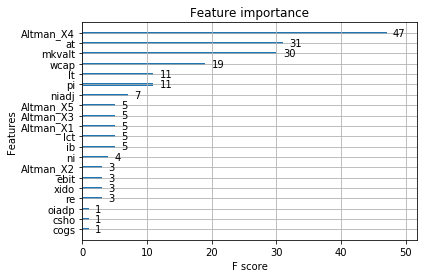

In [277]:

16
# plot feature importance using built-in function
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
# load data
dataset = train4_new
# split data into X and y
X = train4_new.drop(['bankrupt'], axis=1)
y = train4_new.bankrupt
# fit model no training data
model = xgboost_model
model.fit(X, y)
# plot feature importance
plot_importance(model)
pyplot.show()